# Выпускной проект Телеком

<b>Оператор связи «ТелеДом» хочет бороться с оттоком клиентов.</b> Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

<b>Описание услуг</b>
Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

<b>Данные хранятся в базе данных PostgreSQL.</b> Она состоит из нескольких таблиц:
- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

<b>Таблица telecom.contract</b>
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

<b>Таблица telecom.personal</b>
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

<b>Таблица telecom.internet</b>
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;

<b>DeviceProtection — антивирус;</b>
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

<b>Таблица telecom.phone
- customerID — ID пользователя;</b>
- MultipleLines — подключение телефона к нескольким линиям одновременно.

<b>Информация о договорах актуальна на 1 февраля 2020.

In [1]:
# !pip install pandas seaborn catboost imblearn phik sqlalchemy scikit-learn psycopg2

In [2]:
import warnings

import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from pandas.core.dtypes.common import is_string_dtype

from sqlalchemy import create_engine, text
warnings.filterwarnings('ignore')

# Загрузка данных из PostgreSQL

Необходимо проверить подключение к базе данных и возможность загрузки всех требуемых таблиц.


In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # хост
    'port': 6432, # порт подключения
    'db': 'data-science-final' # название базы данных,
}
RANDOM_STATE = 230424 # используем везде эту константу для воспроизводимости данных

In [4]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
))

In [5]:
# функция для первичного анализа датафрейма
def describe_dataframe(dataframe):
    display(dataframe.head(10))
    dataframe.info()
    display(dataframe.describe(percentiles=[.5]).T)
    print(f"Количество дублированных строк: {dataframe.duplicated().sum()}")

# функция для загрузки таблицы в датафрейм
def sql_to_dataframe(sql, engine=engine, index_col=None):
    return pd.read_sql_query(text(sql), con = engine.connect(), index_col=index_col)

# функция для скачивания первичных данных
def get_table(table_name, engine=engine, index_col=None):
    sql = f"""SELECT * FROM {table_name}"""
    return sql_to_dataframe(sql, engine, index_col)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Исполнил
</div>

In [6]:
contract = get_table('telecom.contract', index_col=['customerID'])
personal = get_table('telecom.personal', index_col=['customerID'])
internet = get_table('telecom.internet', engine)
phone = get_table('telecom.phone', engine)

In [7]:
internet = internet.rename(columns=internet.iloc[0]).drop(internet.index[0]).set_index('customerID')
phone = phone.rename(columns=phone.iloc[0]).drop(phone.index[0]).set_index('customerID')

Вывод: Подключение произошло успешно, а требуемые таблицы загружены.

# Проведение исследовательского анализа данных

Проанализируйте исходные данные. Проверьте:

    Все ли таблицы содержат данные.
    Соответствует ли количество таблиц условию задачи.

Для каждой таблицы:

    Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
    Обработайте аномалии с учётом особенностей услуг телекоммуникации.

Объедините таблицы по ID клиента:

    Каждому клиенту должно соответствовать одно наблюдение. При объединении учитывайте особенности услуг телекоммуникации.
    Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении. Например, рассчитайте длительность контракта абонента.
    Выделите в целевую переменную признак EndDate.
    Проведите исследовательский анализ данных объединённой таблицы, при необходимости заполните пропуски и визуализируйте распределение каждого признака.
    Визуализируйте соотношение ушедших и оставшихся клиентов для каждого признака.
    Проведите корреляционный анализ.

Подготовьте данные для обучения:

    Выберите признаки, которые будете использовать для обучения, учитывайте особенности данных и выбранных моделей. Перед вами не стоит задача временных рядов, поэтому не стоит использовать даты как входные признаки модели.
    Если вы сгенерируете новый признак «Длительность контракта абонента», то не используйте его одновременно с любыми другими производными признака BeginDate — например с годом заключения договора. Это приведёт к утечке целевого признака.
    Разделите данные на тренировочную и тестовую выборки (test_size = 0.25).
    Подготовьте выборки для обучения, учитывайте особенности выбранных моделей

## Исследование каждой таблицы

In [8]:
# функция для построения столбчатой диаграммы
def bar_plot(df, x, height=5, title=None):
    if title is None:
        title = f'График по столбцу {x}'
    # Добавляем заголовок
    plt.title(title)
    # Отображаем график
    plt.bar(df[x], height)

# функция для построения гистограммы
def gist_plot(df, x, bins=20, title=None):
    if title is None:
        title = f'График по столбцу {x}'
    # Создаем график
    plt.figure(figsize=(14, 8)) # Задаем размер графика
    # Строим график с помощью функции plot
    plt.hist(df[x], bins=bins)
    # Добавляем заголовок и метки осей
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel('stars count')
    # Отображаем график
    plt.show()

In [9]:
# функция для построения круговой диаграммы
def print_pie(grouped):
    sizes = grouped
    labels = grouped.index
    # Создаем график
    fig1, ax1 = plt.subplots(figsize=(6, 5))
    fig1.subplots_adjust(0.3,0,1.5,1)
    theme = plt.get_cmap('bwr')
    ax1.set_prop_cycle("color", [theme(1.3 * i / len(sizes)) for i in range(len(sizes))])
    ax1.pie(sizes, startangle=90)
    ax1.axis('equal')
    total = sum(sizes)
    # Добавляем заголовок и метки осей
    plt.legend(
        loc='upper left',
        labels=['%s, %1.1f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
        prop={'size': 11},
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure)
    # Отображаем график
    plt.show();

# temp = collisions.merge(vehicles.query("vehicle_transmission == 'manual'"), on='case_id')
# print_pie(temp.groupby('pcf_violation_category').size())

In [10]:
# Построим матрицу корреляции
def correlation_matrix(model_query, interval_cols):
    phik_overview = model_query.phik_matrix(interval_cols=interval_cols)
    phik_overview.round(2)

    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=-1,
        vmax=1,
        title=r"Корреляция $\phi_K$",
        fontsize_factor=0.8,
        figsize=(8, 6)
    );
    return phik_overview

In [11]:
# Определение функций для отображения распределения категорий
def display_objects(dataframe):
    object_columns = filter(lambda column: is_string_dtype(dataframe[column]), dataframe.columns)
    for i, column in enumerate(object_columns, 1):
        display(f"{i} Категориальная колонка: {column}")
        display(dataframe[column].value_counts())
        if len(dataframe[column].value_counts()) > 50:
            continue
        print_pie(dataframe.groupby(column).size())

# Определение функций для отображения распределения бинарных параметров
def display_digits(dataframe):
    digit_columns = filter(lambda column: not is_string_dtype(dataframe[column]), dataframe.columns)
    for i, column in enumerate(digit_columns, 1):
        display(f"{i} Численная колонка: {column}")
        display(dataframe[column].value_counts())
        gist_plot(dataframe, column)

### Проверка связей таблиц

In [12]:
display(sum(personal.index.isin(contract.index)) == len(personal))

True

In [13]:
display(sum(internet.index.isin(contract.index)) == len(internet))

True

In [14]:
display(sum(phone.index.isin(contract.index)) == len(phone))

True

Вывод: Идентификаторы клиентов в побочных таблицах phone, internet и personal полностью соответствуют идентификаторам таблицы с описанием клиентов contract.

### Таблица contract

In [15]:
describe_dataframe(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           1869 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(5)
memory usage: 440.2+ KB


,count,mean,std,min,50%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,70.350,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,1397.475,8684.80


Количество дублированных строк: 0


'1 Категориальная колонка: Type'

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

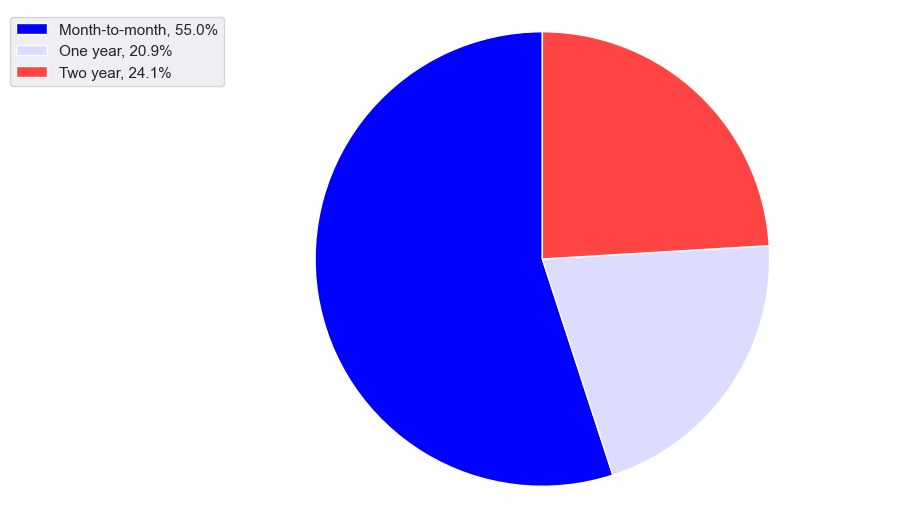

'2 Категориальная колонка: PaperlessBilling'

PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

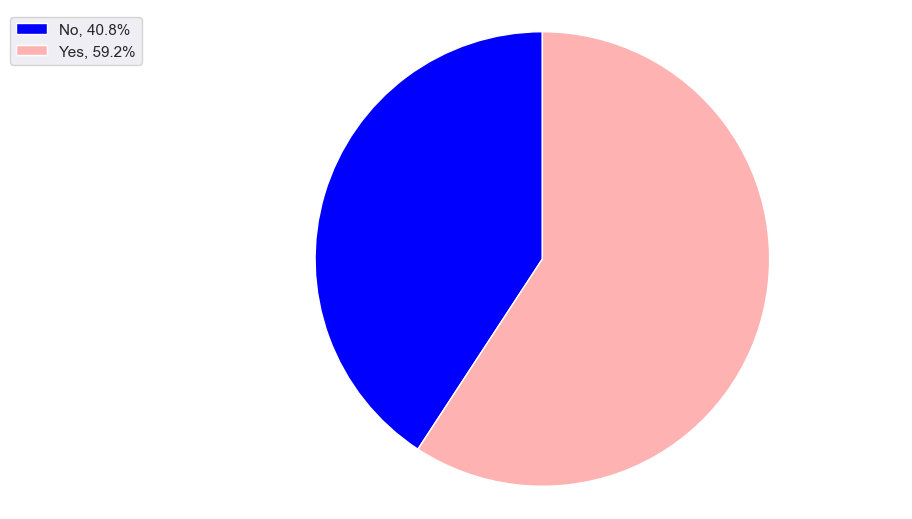

'3 Категориальная колонка: PaymentMethod'

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

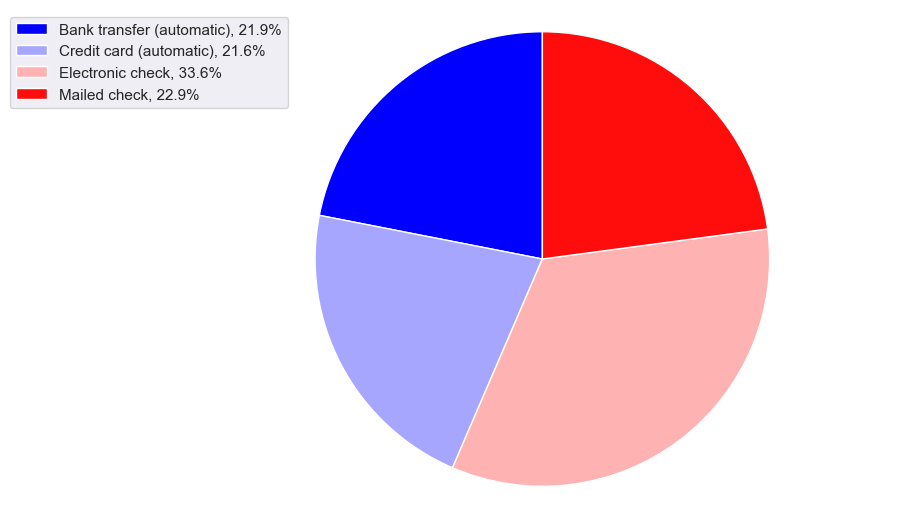

In [16]:
display_objects(contract)

'1 Численная колонка: BeginDate'

BeginDate
2019-03-24    43
2019-03-13    43
2019-04-03    41
2019-04-08    41
2019-03-09    41
              ..
2018-06-07     1
2018-07-18     1
2018-08-02     1
2018-04-28     1
2019-10-12     1
Name: count, Length: 515, dtype: int64

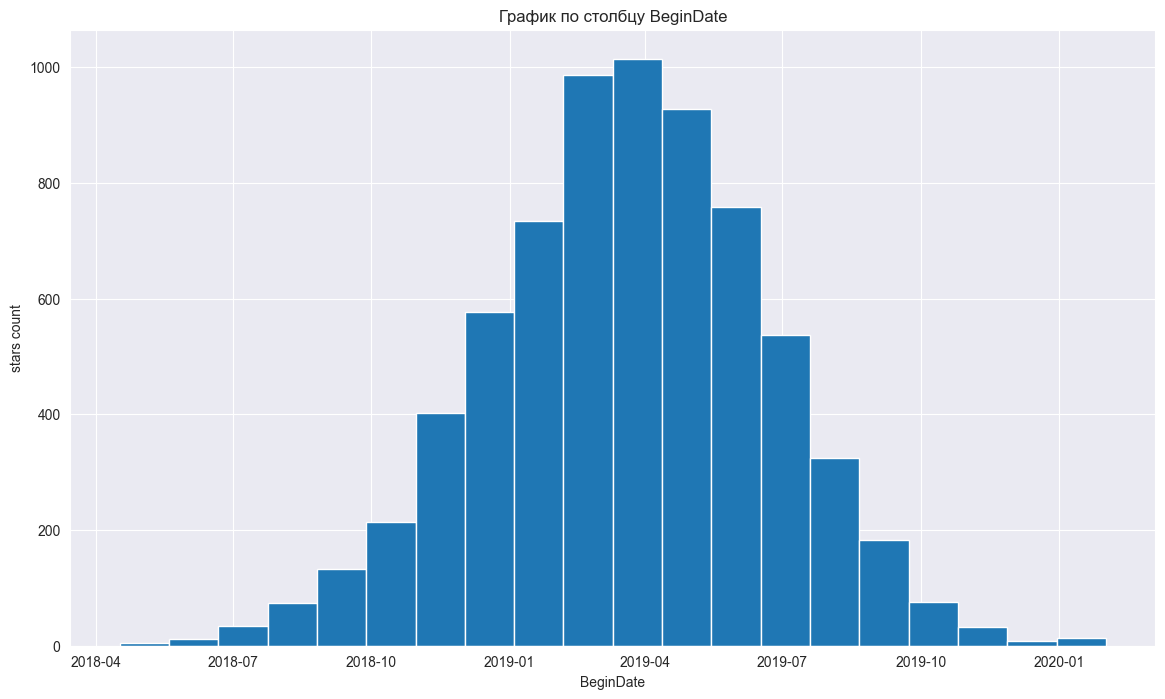

'2 Численная колонка: EndDate'

EndDate
2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: count, dtype: int64

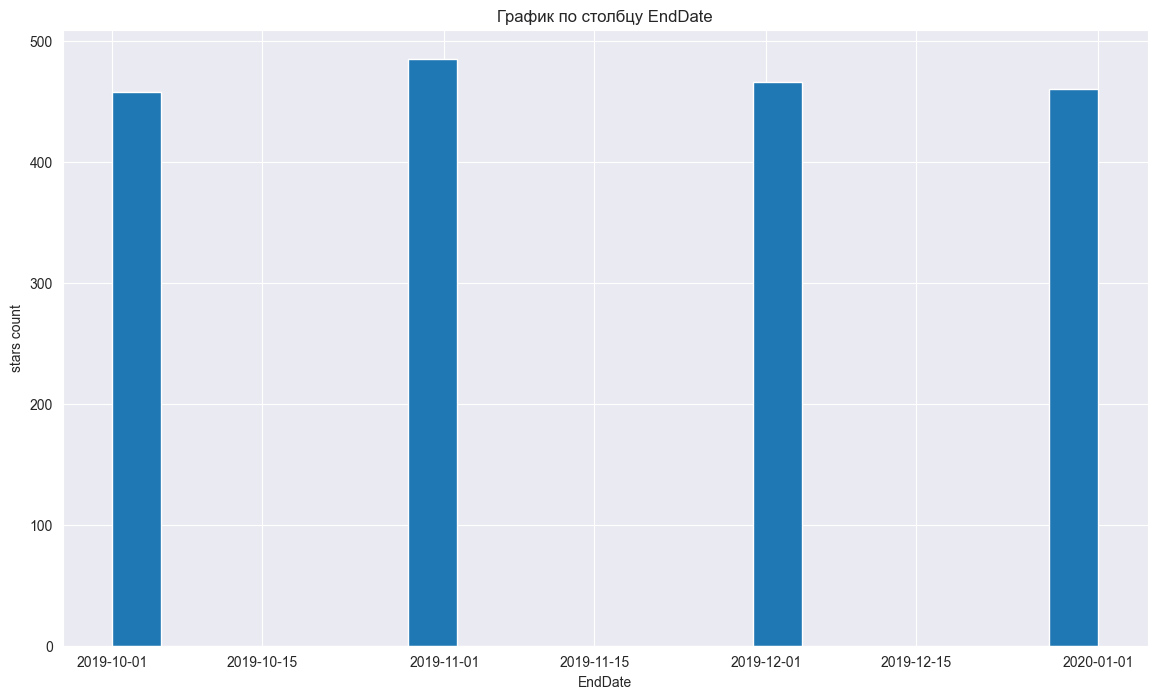

'3 Численная колонка: MonthlyCharges'

MonthlyCharges
20.05    61
19.85    45
19.90    44
19.95    44
20.00    43
         ..
65.75     1
87.90     1
93.45     1
82.70     1
78.70     1
Name: count, Length: 1585, dtype: int64

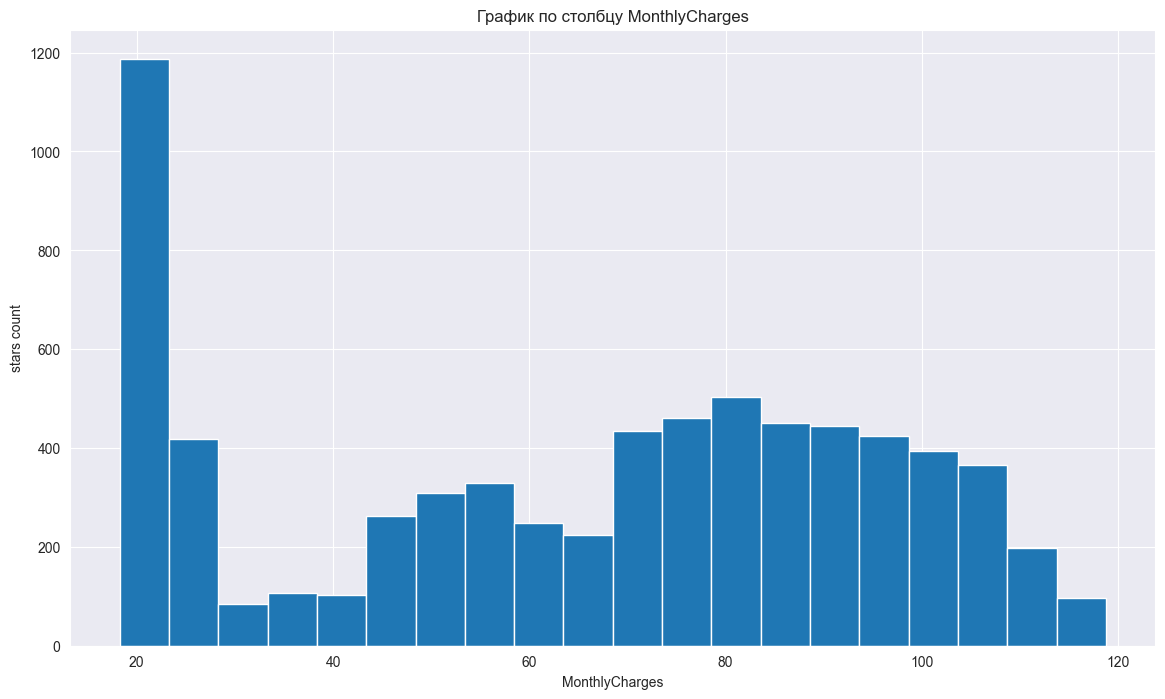

'4 Численная колонка: TotalCharges'

TotalCharges
20.20      11
19.75       9
19.65       8
19.90       8
20.05       8
           ..
3340.55     1
5222.30     1
963.95      1
1442.60     1
6844.50     1
Name: count, Length: 6530, dtype: int64

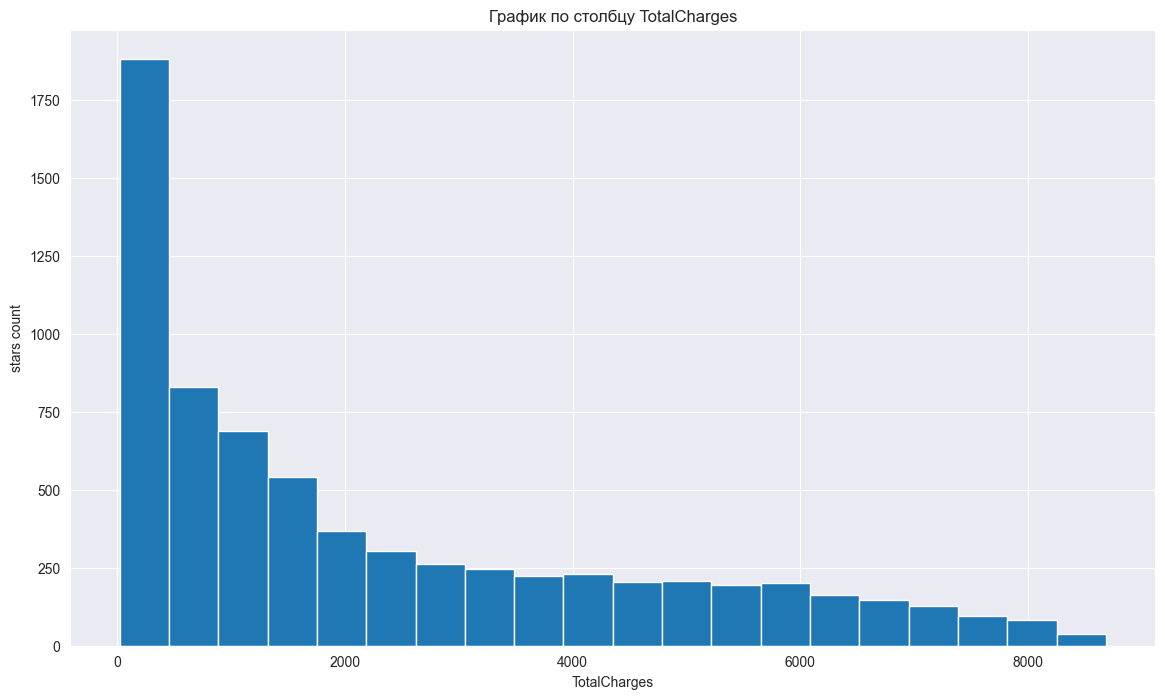

In [17]:
display_digits(contract)

### Таблица personal

In [18]:
describe_dataframe(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,count,mean,std,min,50%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,1.0


Количество дублированных строк: 7027


'1 Категориальная колонка: gender'

gender
Male      3555
Female    3488
Name: count, dtype: int64

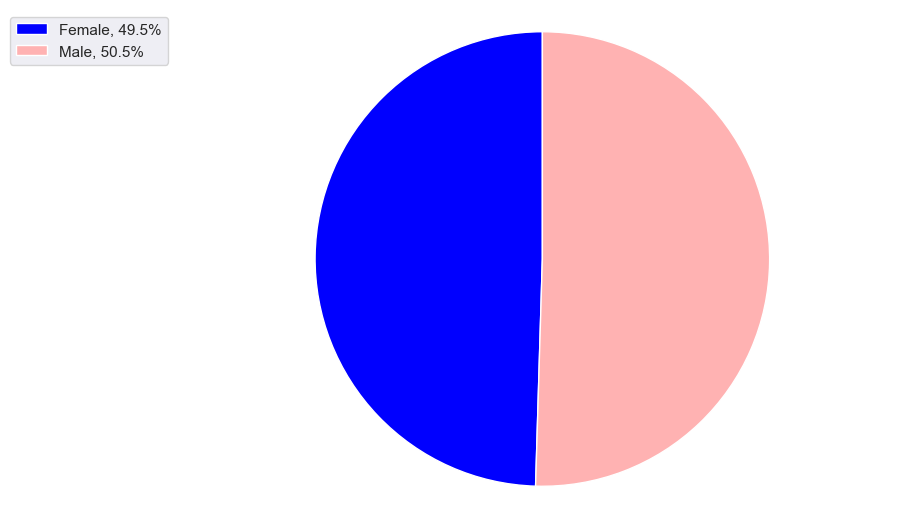

'2 Категориальная колонка: Partner'

Partner
No     3641
Yes    3402
Name: count, dtype: int64

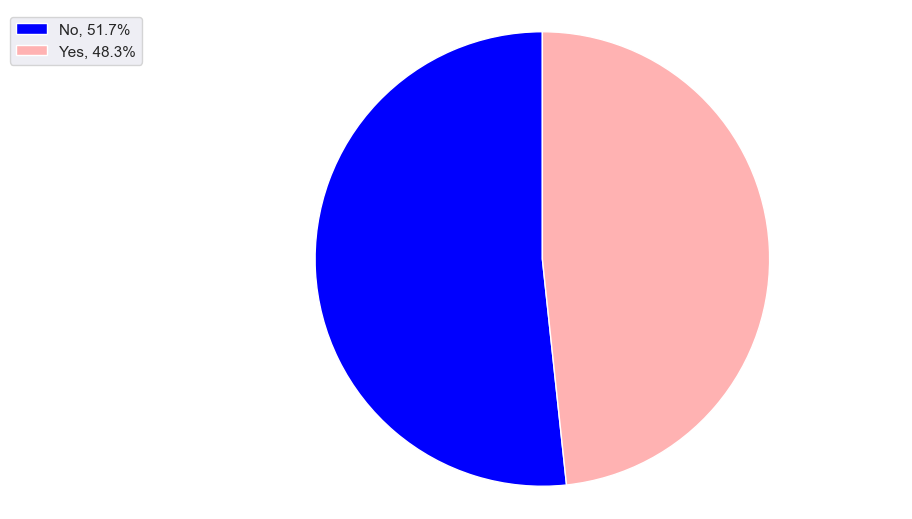

'3 Категориальная колонка: Dependents'

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

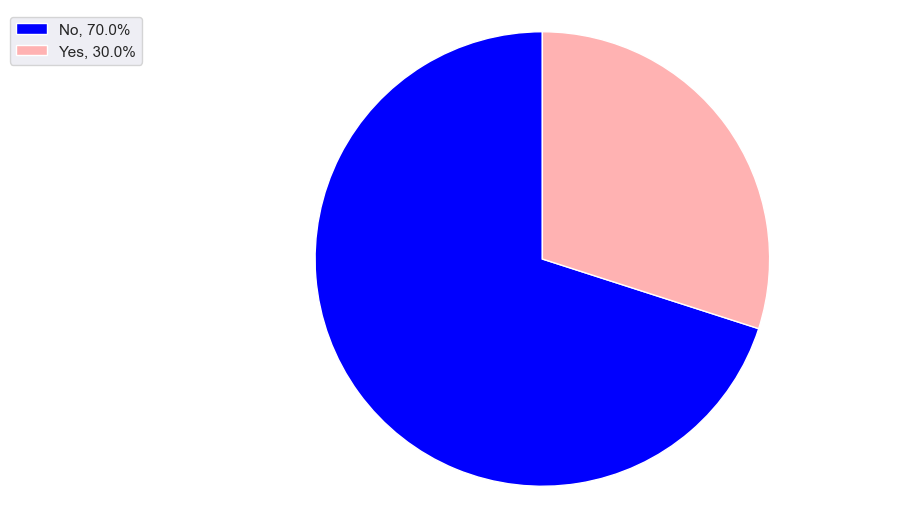

In [19]:
display_objects(personal)

'1 Численная колонка: SeniorCitizen'

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

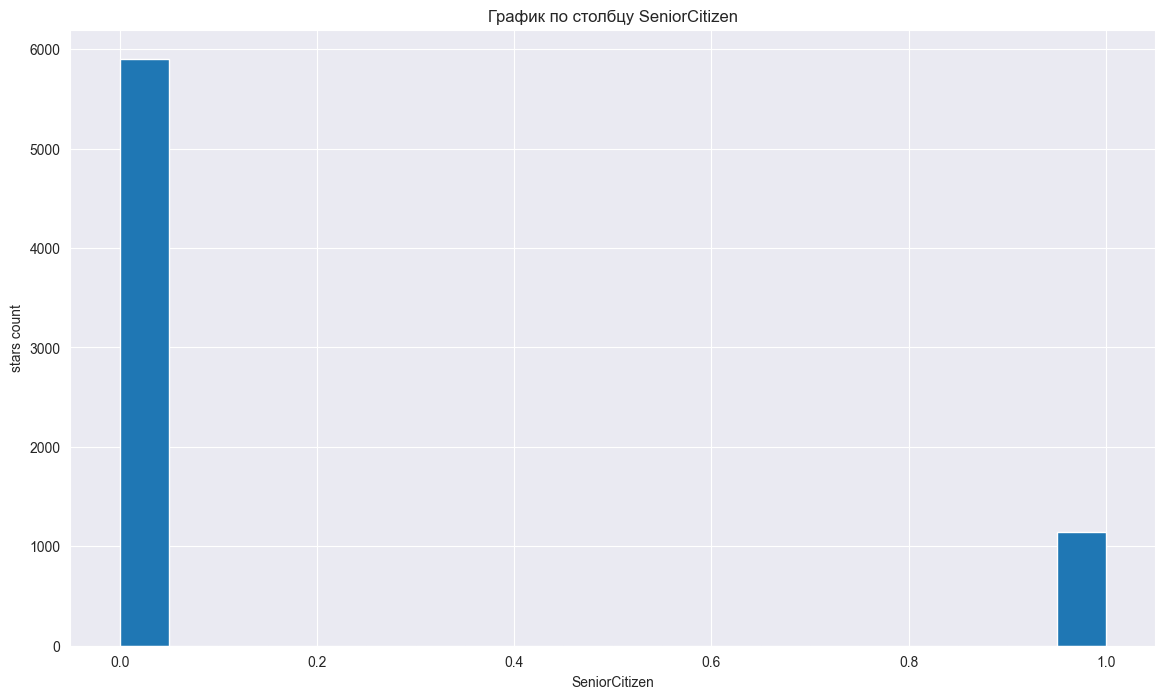

In [20]:
display_digits(personal)

### Таблица internet

In [21]:
describe_dataframe(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,count,unique,top,freq
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


Количество дублированных строк: 5389


'1 Категориальная колонка: InternetService'

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

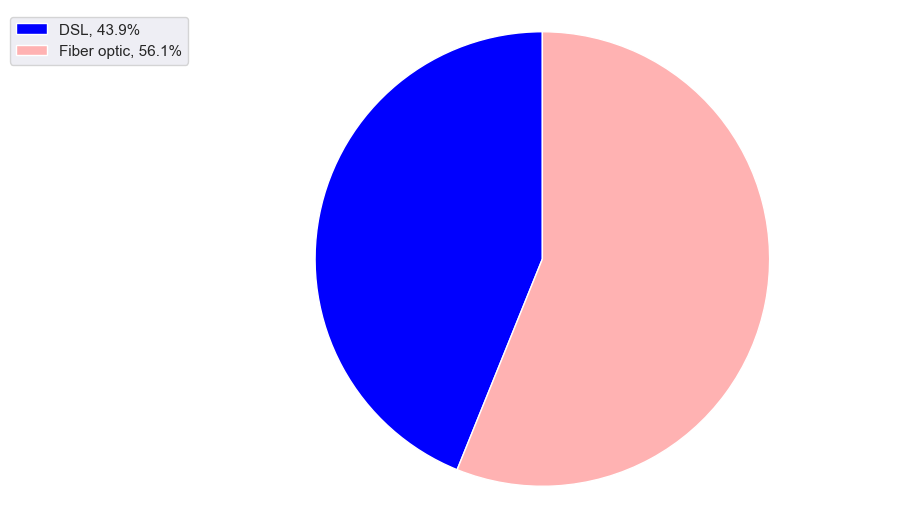

'2 Категориальная колонка: OnlineSecurity'

OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

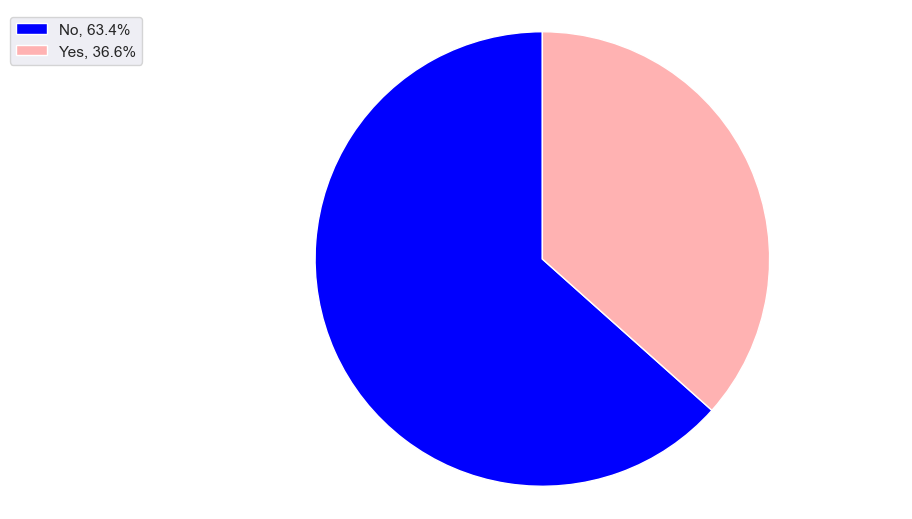

'3 Категориальная колонка: OnlineBackup'

OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

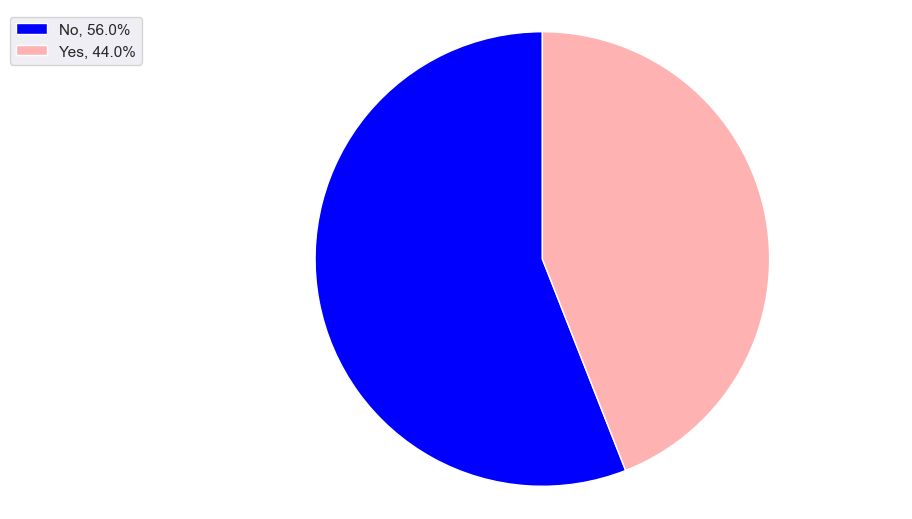

'4 Категориальная колонка: DeviceProtection'

DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

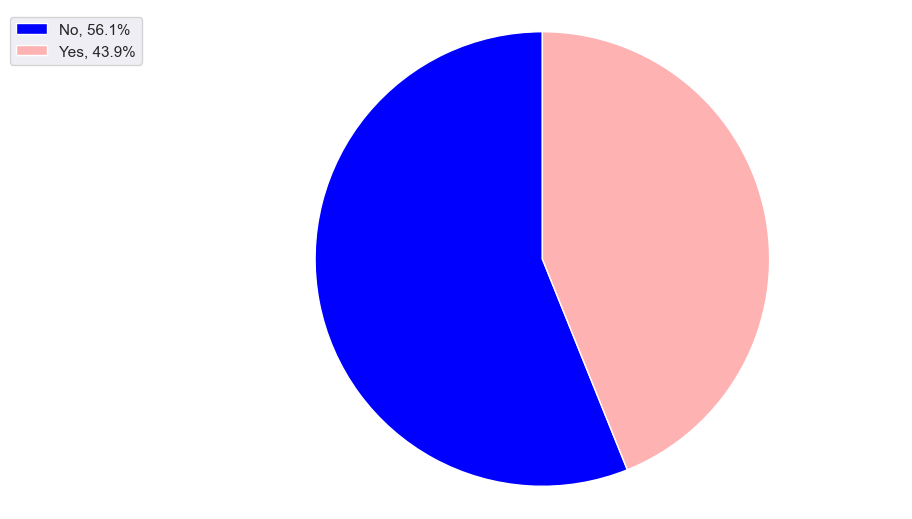

'5 Категориальная колонка: TechSupport'

TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

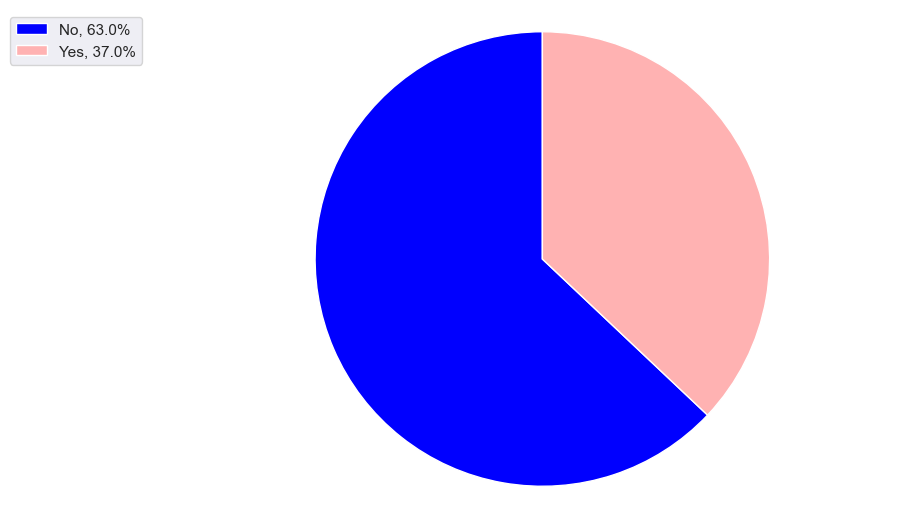

'6 Категориальная колонка: StreamingTV'

StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

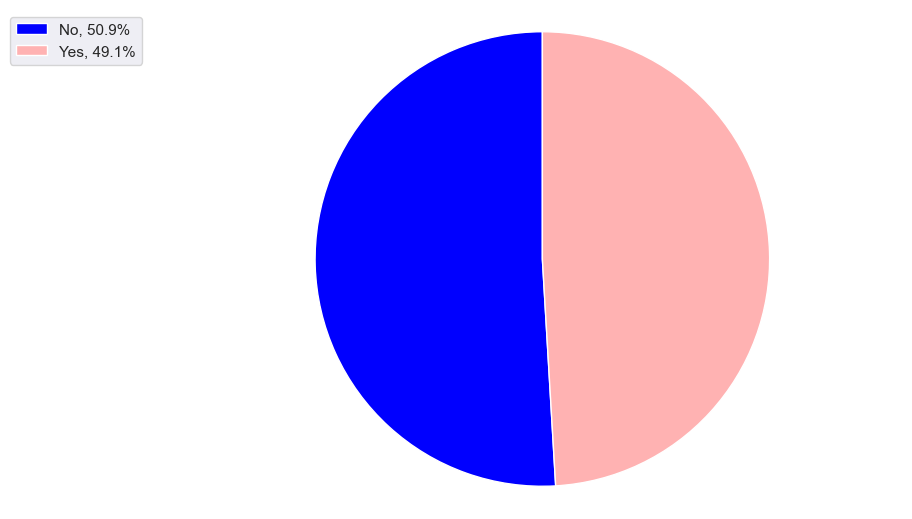

'7 Категориальная колонка: StreamingMovies'

StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64

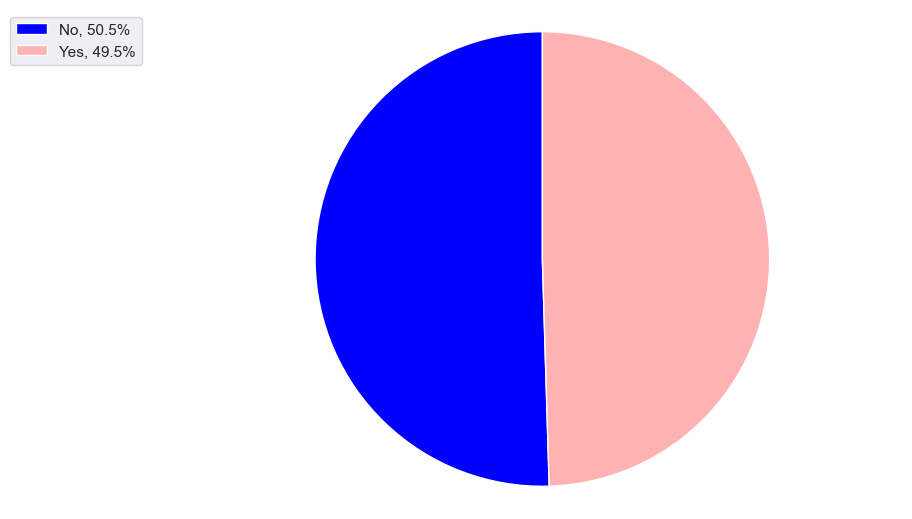

In [22]:
display_objects(internet)

### Таблица phone

In [23]:
describe_dataframe(phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,count,unique,top,freq
MultipleLines,6361,2,No,3390


Количество дублированных строк: 6359


'1 Категориальная колонка: MultipleLines'

MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64

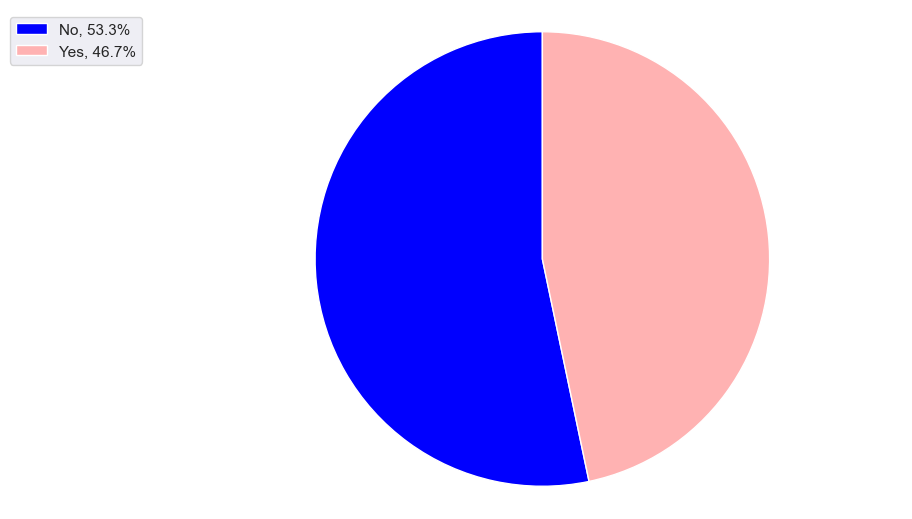

In [24]:
display_objects(phone)

## Объединение таблиц

In [25]:
df_merged = pd.merge(contract, personal, on='customerID', how='outer')
df_merged = pd.merge(df_merged, internet, on='customerID', how='outer')
df_merged = pd.merge(df_merged, phone, on='customerID', how='outer')

In [26]:
describe_dataframe(df_merged)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-02-08,None,One year,Yes,Mailed check,65.60,593.30,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
0003-MKNFE,2018-11-13,None,Month-to-month,No,Mailed check,59.90,542.40,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
0004-TLHLJ,2019-04-16,2020-01-01,Month-to-month,Yes,Electronic check,73.90,280.85,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
0011-IGKFF,2019-04-12,2020-01-01,Month-to-month,Yes,Electronic check,98.00,1237.85,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
0013-EXCHZ,2019-03-17,2019-12-01,Month-to-month,Yes,Mailed check,83.90,267.40,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No
0013-MHZWF,2019-10-06,None,Month-to-month,Yes,Credit card (automatic),69.40,571.45,Female,0,No,Yes,DSL,No,No,No,Yes,Yes,Yes,No
0013-SMEOE,2019-03-14,None,Two year,Yes,Bank transfer (automatic),109.70,7904.25,Female,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No
0014-BMAQU,2019-02-04,None,Two year,Yes,Credit card (automatic),84.65,5377.80,Male,0,Yes,No,Fiber optic,Yes,No,No,Yes,No,No,Yes
0015-UOCOJ,2018-06-28,None,Month-to-month,Yes,Electronic check,48.20,340.35,Female,1,No,No,DSL,Yes,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           1869 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

,count,mean,std,min,50%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,70.350,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,1397.475,8684.80
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,1.00


Количество дублированных строк: 0


## Подготовка данных для обучения

In [27]:
def plot_time_frequency(series, title='Распределение времени даты начала договора клиета', label='Частота'):
    plt.hist(pd.to_datetime(series), bins=21, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel(label)
    plt.xticks(rotation=45)  # Rotate labels for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show();

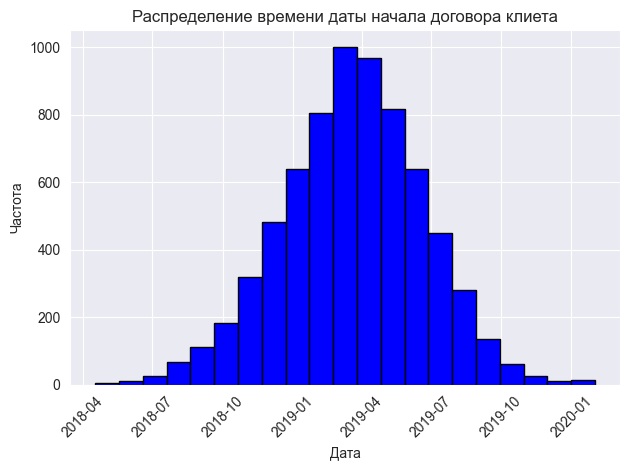

In [28]:
plot_time_frequency(df_merged['BeginDate'], 'Распределение времени даты начала договора клиета', 'Частота')

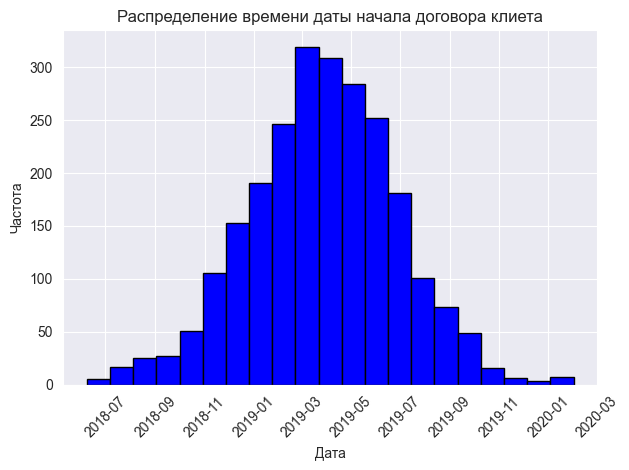

In [29]:
plot_time_frequency(df_merged.query('InternetService == "DSL"')['BeginDate'], 'Распределение времени даты начала договора клиета', 'Частота')

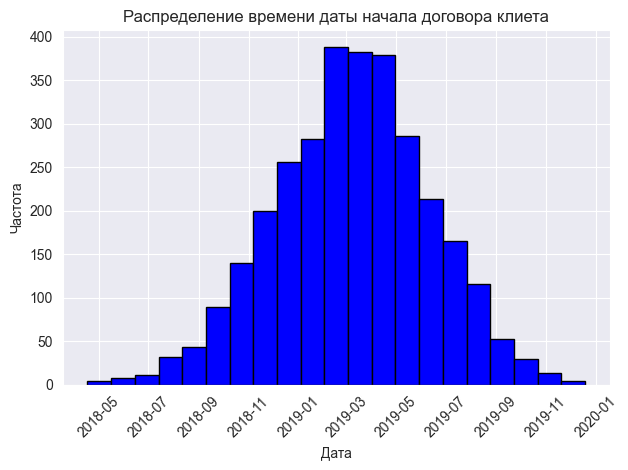

In [30]:
plot_time_frequency(df_merged.query('InternetService == "Fiber optic"')['BeginDate'], 'Распределение времени даты начала договора клиета', 'Частота')

In [31]:
print('Верно ли утверждение, что данные из столбца TotalCharges равны NaN в том случае, если человек стал пользователем компании в deadline сбора данных (1 февраля 2022 года):',
      (contract.loc[contract.TotalCharges.isna()].index == contract.loc[contract['BeginDate'] == datetime.date(2020, 2, 1)].index).all())

Верно ли утверждение, что данные из столбца TotalCharges равны NaN в том случае, если человек стал пользователем компании в deadline сбора данных (1 февраля 2022 года): True


Необходимо удалить данные в которых столбец TotalCharges пуст, также преобразуем колонки EndDate и BeginDate в более удобные признаки, а сами колонки удалим. Добавим следующие искусственные параметры:
- target: Целевая переменная
- duration: Общая длительность договора с клиентом
- time_to_pay: Время до следующего платежа по договору

In [32]:
df_merged['target'] = df_merged['EndDate'].apply(lambda x: 1 if x is not None else 0)
df_merged['EndDate'] = df_merged['EndDate'].fillna('2020-02-01')
df_merged['EndDate'] = pd.to_datetime(df_merged['EndDate'])
df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'])
df_merged['duration'] = (df_merged['EndDate'] - df_merged['BeginDate']).dt.days
# df_merged = df_merged.drop(columns=['BeginDate', 'EndDate'])

Проведённый выше исследовательский анализ связи таблиц показал, что все таблицы internet и phone всязаны с таблицей contract с помощью уникального id клиента, все id если в этой таблице, следовательно можно сделать следующий вывод:
Если у пользователя в целом нет услуг интернета или телефона, то его не будет в соответствующих таблицах.
Поэтому пропуски в данных категориях можно заполнить следующими способами:
- Заполнить пропуски No (отрицательным значенинем)
- Заполнить пропуски дополнительными категориальными переменными: NoInternet, NoPhone

Я считаю, что раз клиент в целом не пользуется либо услугами телефонии, либо интернетом, то это необходимо выделить соответствующими категориальными переменными.

In [33]:
df_merged.dropna(axis=0, subset=['TotalCharges'], inplace=True)
NoPhone = ['MultipleLines']
NoInternet = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_merged[NoPhone] = df_merged[NoPhone].fillna('NoPhone')
df_merged[NoInternet] = df_merged[NoInternet].fillna('NoInternet')

In [34]:
df_merged.loc[df_merged['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
df_merged.loc[df_merged['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

In [35]:
# Подсчитаем количество дней, которые остались до оплаты пользования за следующий период

def days_before_payment(row):
    if row['Type'] == 'Month-to-month':
        return 30 - row['duration'] % 30  # row['duration'] % 30
    elif row['Type'] == 'One year':
        return 365 - row['duration'] % 365
    return 730 - row['duration'] % 730

df_merged['time_to_pay'] = df_merged.apply(days_before_payment, axis=1)

In [36]:
df_merged = df_merged.drop(columns=['BeginDate', 'EndDate'])

In [37]:
describe_dataframe(df_merged)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration,time_to_pay
customerID,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,One year,Yes,Mailed check,65.60,593.30,Female,No,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,0,358,7
0003-MKNFE,Month-to-month,No,Mailed check,59.90,542.40,Male,No,No,No,DSL,No,No,No,No,No,Yes,Yes,0,445,5
0004-TLHLJ,Month-to-month,Yes,Electronic check,73.90,280.85,Male,No,No,No,Fiber optic,No,No,Yes,No,No,No,No,1,260,10
0011-IGKFF,Month-to-month,Yes,Electronic check,98.00,1237.85,Male,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,1,264,6
0013-EXCHZ,Month-to-month,Yes,Mailed check,83.90,267.40,Female,Yes,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,1,259,11
0013-MHZWF,Month-to-month,Yes,Credit card (automatic),69.40,571.45,Female,No,No,Yes,DSL,No,No,No,Yes,Yes,Yes,No,0,118,2
0013-SMEOE,Two year,Yes,Bank transfer (automatic),109.70,7904.25,Female,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No,0,324,406
0014-BMAQU,Two year,Yes,Credit card (automatic),84.65,5377.80,Male,No,Yes,No,Fiber optic,Yes,No,No,Yes,No,No,Yes,0,362,368
0015-UOCOJ,Month-to-month,Yes,Electronic check,48.20,340.35,Female,Yes,No,No,DSL,Yes,No,No,No,No,No,No,0,583,17


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   object 
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null 

,count,mean,std,min,50%,max
MonthlyCharges,7032.0,64.798208,30.085974,18.25,70.350,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,1397.475,8684.80
target,7032.0,0.265785,0.441782,0.00,0.000,1.00
duration,7032.0,297.843857,83.104180,3.00,298.000,583.00
time_to_pay,7032.0,142.533703,183.059731,1.00,27.000,727.00


Количество дублированных строк: 0


## Корреляционный анализ данных

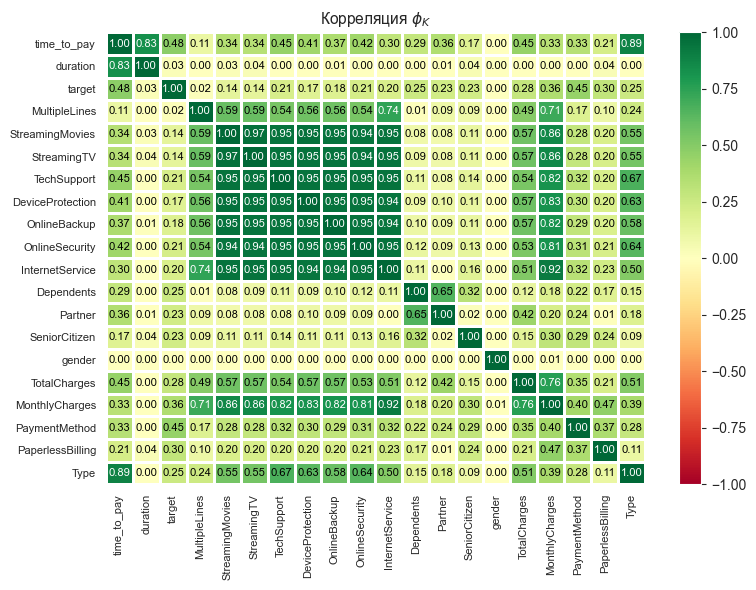

In [38]:
overview = correlation_matrix(df_merged, interval_cols=['time_to_pay', 'duration', 'MonthlyCharges', 'TotalCharges'])

In [39]:
# # Создание списка не мультиколлинеарных признаков
# # со статистически значимой корреляцией с целевым признаком
# def non_multicollinear_features(m, target_feature, v_min, v_max):
#
#     columns = []
#     append = True
#
#     for c in m.columns:
#         if ((m[c][target_feature] > v_min) & (c != target_feature)):
#             for i in m.index:
#                 if ((c != i) & (c != target_feature) & (c not in columns) & (i not in columns)):
#                     if m[c][i] > v_max:
#                         if m[c][target_feature] < m[i][target_feature]:
#                             append = False
#                             break
#             if append == True: columns.append(c)
#             append = True
#
#     return columns
#
# non_multicollinear = non_multicollinear_features(overview, 'target', .03, .75)
#
# print('Не мультиколлинеарные признаки, обладающие статистически значимой парной корреляцией с целевым признаком:')
# non_multicollinear

Вывод по корреляционному анализу данных:
Цветовая шкала справа показывает диапазон коэффициентов корреляции, где 1 означает абсолютную положительную корреляцию (показана зеленым цветом), -1 - абсолютную отрицательную корреляцию (показана красным цветом), а 0 указывает на отсутствие корреляции (показана черным цветом).

Основываясь на этой тепловой карте, мы можем сделать следующие выводы о "target" переменной:

- **Наивысшие положительные параметры**: Это переменные, которые наиболее положительно коррелируют с "target" переменной. Тепловая карта показывает, что "time_to_pay" имеет очень высокую положительную корреляцию с "target" переменной, которая составляет приблизительно 0,48. Это говорит о том, что изменение этого конкретоного параметра явно повлияет на шанс ухода клиента.

- **Отрицательные параметры**: Подобных не обнаружено.

- **Нейтральные параметры**: Считается, что переменные, коэффициенты корреляции которых близки к 0, практически не имеют линейной связи с "target". Например, такие переменные, как ["gender", "duration", "MultiplyLines"] с коэффициентом 0,00, были бы нейтральными по отношению к "target", что указывает на отсутствие линейной корреляции.

Необходимо учитывать возможность смешения переменных или нелинейных зависимостей, которые не учитываются корреляционной матрицей.

Корреляция не подразумевает причинно-следственной связи, поэтому, хотя эти переменные связаны с "target", это не означает, что одна из них вызывает другую без дальнейшего анализа.

## Исследование распределения целевой переменной по каждому признаку

In [40]:
categorical_features = ['Type',
                        'PaperlessBilling',
                        'PaymentMethod',
                        'gender',
                        'Partner',
                        'Dependents',
                        'InternetService',
                        'OnlineSecurity',
                        'OnlineBackup',
                        'DeviceProtection',
                        'TechSupport',
                        'StreamingTV',
                        'StreamingMovies',
                        'MultipleLines',
                        'SeniorCitizen']

In [41]:
def proba_plot(data, column):
    array0 = []
    array1 = []
    unique_list = list(data[column].unique())
    for i in range(len(unique_list)):
        all_unique = data.loc[data[column] == unique_list[i], column].count()

        target_1 = data.loc[(data[column] == unique_list[i]) & (data['target'] == 1), column].count()
        proba1 = np.round((target_1 / all_unique), 2)
        target_0 = data.loc[(data[column] == unique_list[i]) & (data['target'] == 0), column].count()
        proba0 = np.round((target_0 / all_unique), 2)

        array0.append([unique_list[i], proba0, 'Не ушёл'])
        array1.append([unique_list[i], proba1, 'Ушёл'])

    array = np.concatenate([array0, array1], axis=0)
    df = pd.DataFrame(data=array, columns = ['Уникальные значения столбца '+column, 'Доля клиентов', 'Hue'])
    df['Доля клиентов'] = df['Доля клиентов'].astype(float)
    display(df)

    sns.barplot(data = df, x = 'Уникальные значения столбца '+column, y = 'Доля клиентов', hue = 'Hue')
    plt.show()

,Уникальные значения столбца Type,Доля клиентов,Hue
0,One year,0.89,Не ушёл
1,Month-to-month,0.57,Не ушёл
2,Two year,0.97,Не ушёл
3,One year,0.11,Ушёл
4,Month-to-month,0.43,Ушёл
5,Two year,0.03,Ушёл


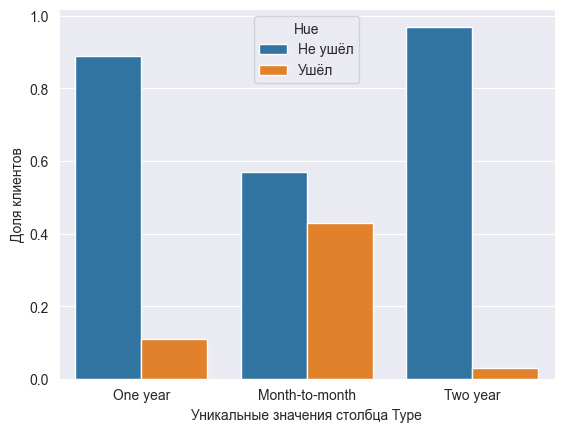

,Уникальные значения столбца PaperlessBilling,Доля клиентов,Hue
0,Yes,0.66,Не ушёл
1,No,0.84,Не ушёл
2,Yes,0.34,Ушёл
3,No,0.16,Ушёл


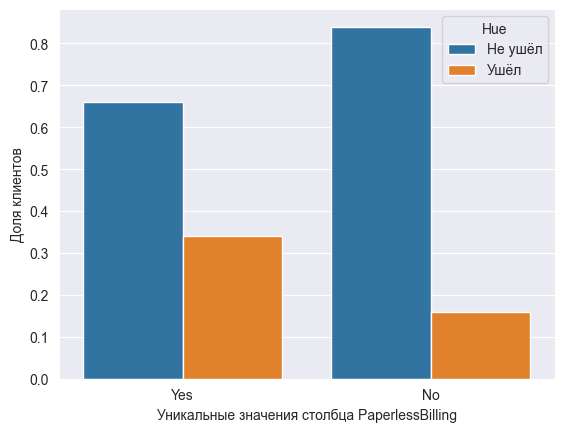

,Уникальные значения столбца PaymentMethod,Доля клиентов,Hue
0,Mailed check,0.81,Не ушёл
1,Electronic check,0.55,Не ушёл
2,Credit card (automatic),0.85,Не ушёл
3,Bank transfer (automatic),0.83,Не ушёл
4,Mailed check,0.19,Ушёл
5,Electronic check,0.45,Ушёл
6,Credit card (automatic),0.15,Ушёл
7,Bank transfer (automatic),0.17,Ушёл


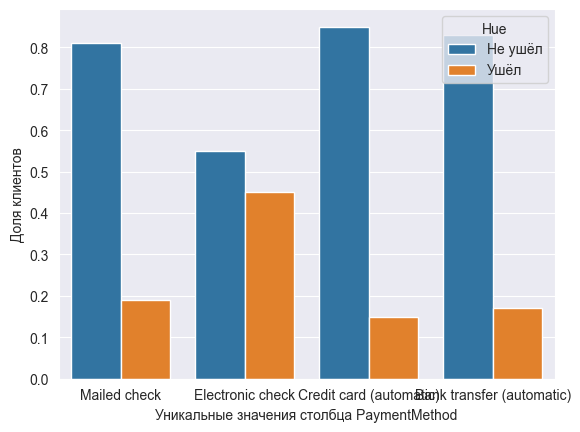

,Уникальные значения столбца gender,Доля клиентов,Hue
0,Female,0.73,Не ушёл
1,Male,0.74,Не ушёл
2,Female,0.27,Ушёл
3,Male,0.26,Ушёл


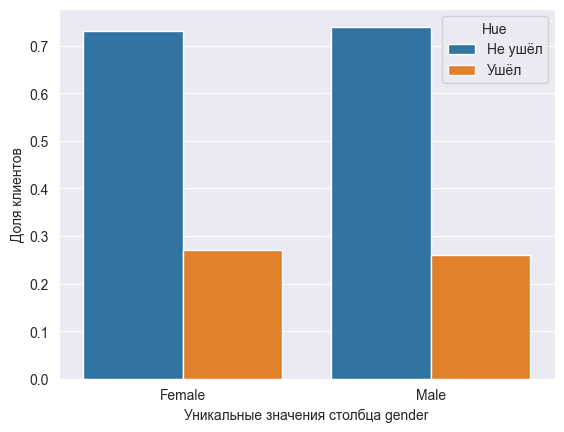

,Уникальные значения столбца Partner,Доля клиентов,Hue
0,Yes,0.80,Не ушёл
1,No,0.67,Не ушёл
2,Yes,0.20,Ушёл
3,No,0.33,Ушёл


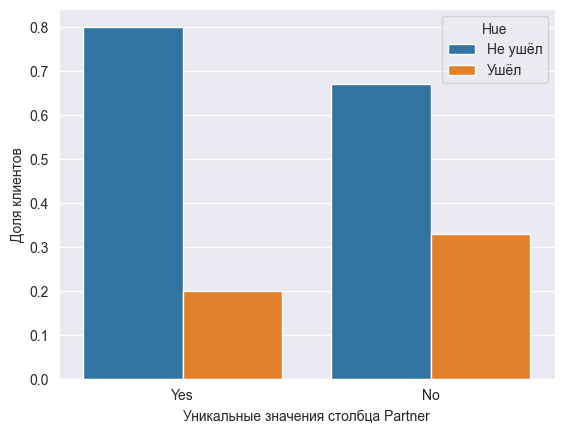

,Уникальные значения столбца Dependents,Доля клиентов,Hue
0,Yes,0.84,Не ушёл
1,No,0.69,Не ушёл
2,Yes,0.16,Ушёл
3,No,0.31,Ушёл


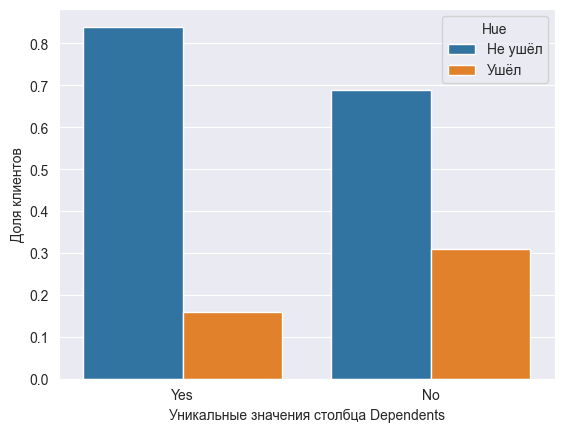

,Уникальные значения столбца InternetService,Доля клиентов,Hue
0,DSL,0.81,Не ушёл
1,Fiber optic,0.58,Не ушёл
2,NoInternet,0.93,Не ушёл
3,DSL,0.19,Ушёл
4,Fiber optic,0.42,Ушёл
5,NoInternet,0.07,Ушёл


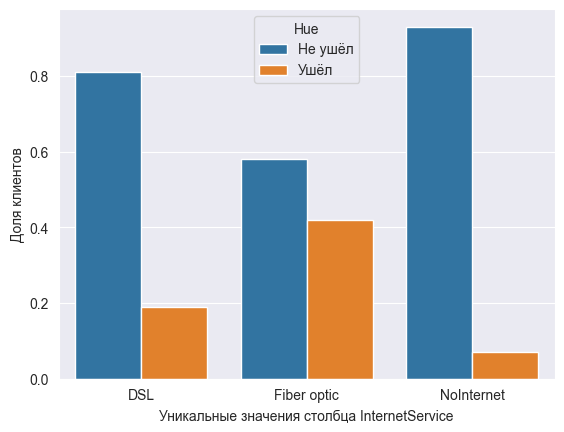

,Уникальные значения столбца OnlineSecurity,Доля клиентов,Hue
0,No,0.58,Не ушёл
1,Yes,0.85,Не ушёл
2,NoInternet,0.93,Не ушёл
3,No,0.42,Ушёл
4,Yes,0.15,Ушёл
5,NoInternet,0.07,Ушёл


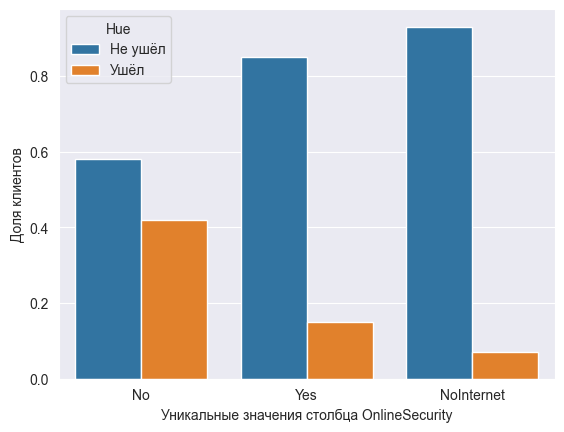

,Уникальные значения столбца OnlineBackup,Доля клиентов,Hue
0,Yes,0.78,Не ушёл
1,No,0.60,Не ушёл
2,NoInternet,0.93,Не ушёл
3,Yes,0.22,Ушёл
4,No,0.40,Ушёл
5,NoInternet,0.07,Ушёл


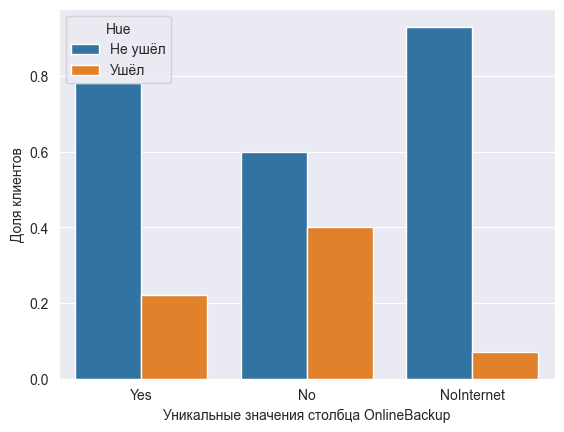

,Уникальные значения столбца DeviceProtection,Доля клиентов,Hue
0,No,0.61,Не ушёл
1,Yes,0.77,Не ушёл
2,NoInternet,0.93,Не ушёл
3,No,0.39,Ушёл
4,Yes,0.23,Ушёл
5,NoInternet,0.07,Ушёл


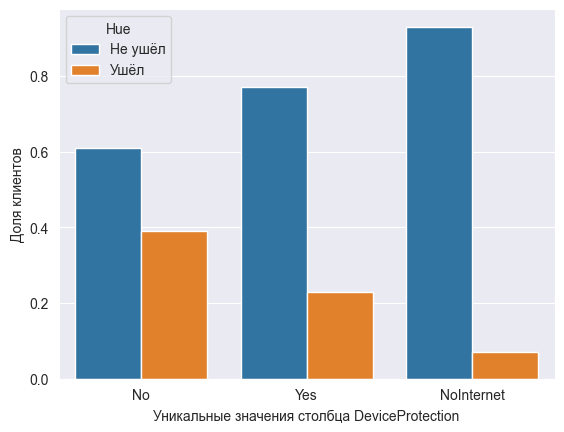

,Уникальные значения столбца TechSupport,Доля клиентов,Hue
0,Yes,0.85,Не ушёл
1,No,0.58,Не ушёл
2,NoInternet,0.93,Не ушёл
3,Yes,0.15,Ушёл
4,No,0.42,Ушёл
5,NoInternet,0.07,Ушёл


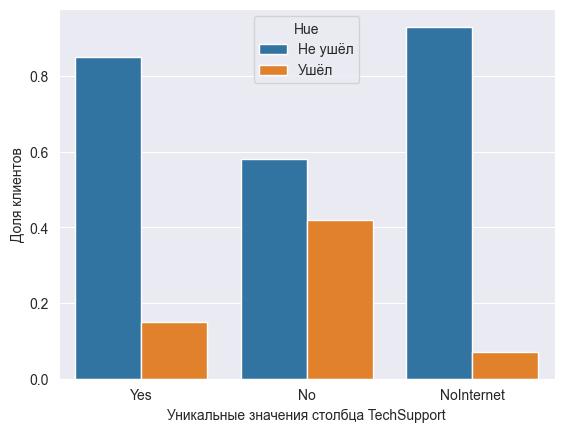

,Уникальные значения столбца StreamingTV,Доля клиентов,Hue
0,Yes,0.70,Не ушёл
1,No,0.66,Не ушёл
2,NoInternet,0.93,Не ушёл
3,Yes,0.30,Ушёл
4,No,0.34,Ушёл
5,NoInternet,0.07,Ушёл


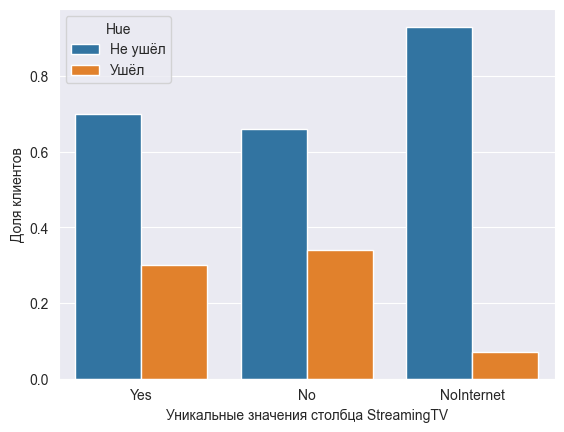

,Уникальные значения столбца StreamingMovies,Доля клиентов,Hue
0,No,0.66,Не ушёл
1,Yes,0.70,Не ушёл
2,NoInternet,0.93,Не ушёл
3,No,0.34,Ушёл
4,Yes,0.30,Ушёл
5,NoInternet,0.07,Ушёл


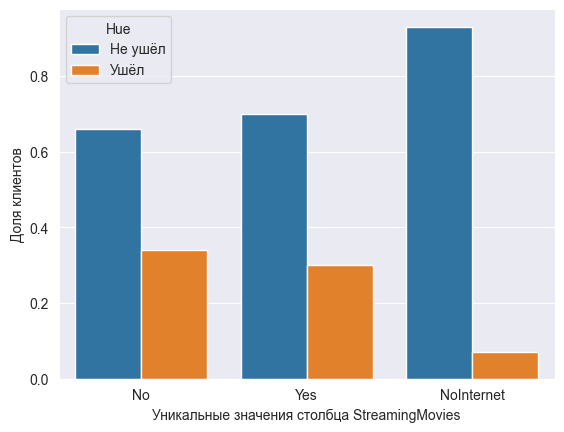

,Уникальные значения столбца MultipleLines,Доля клиентов,Hue
0,No,0.75,Не ушёл
1,Yes,0.71,Не ушёл
2,NoPhone,0.75,Не ушёл
3,No,0.25,Ушёл
4,Yes,0.29,Ушёл
5,NoPhone,0.25,Ушёл


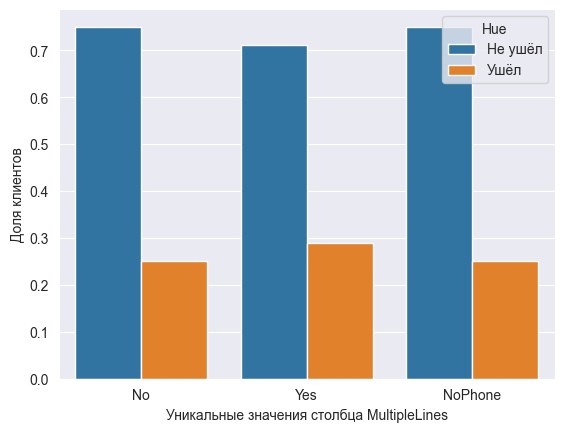

,Уникальные значения столбца SeniorCitizen,Доля клиентов,Hue
0,No,0.76,Не ушёл
1,Yes,0.58,Не ушёл
2,No,0.24,Ушёл
3,Yes,0.42,Ушёл


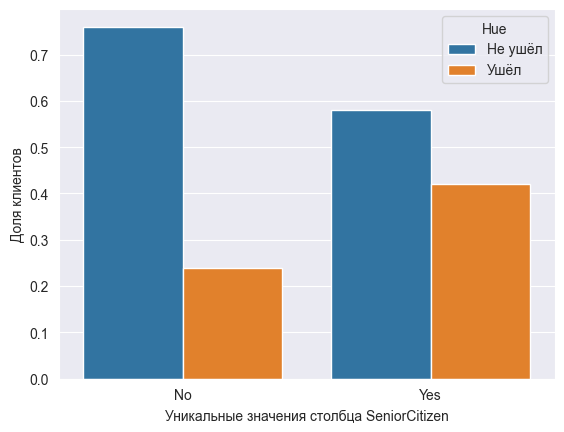

In [42]:
for column in categorical_features:
    proba_plot(df_merged, column)

Анализ данных
После анализа данных можно сделать следующие выводы:
- Пожилые люди (SeniorCitizen) чаще отказываются от услуг, чем более молодые клиенты.
- Во всех категориях (MultiplineLines, SteamingMovies, StreamingTV) наблюдается примерно одинаковое распределение отказов от услуг.
- Пользователи без доступа в интернет реже отказываются от услуг, чем те, у кого есть доступ.
- Пользователи с приоритетной технической поддержкой (TechSupport) гораздо реже отказываются от услуг.
- Пользователи с дополнительной услугой DeviceProtection чаще отказываются от услуг.
- Пользователи с услугой OnlineBackup в 2 раза реже отказываются от услуг по сравнению с теми, у кого бэкапа нет.
- Пользователи с услугой OnliveSecurity реже отказываются от услуг.
- Пользователи с услугой InternetService реже отказываются от услуг.
- Одинокие люди (Partner и Dependence) чаще меняют провайдера.
- Пользователи, которые используют электронные чеки (PaymentMethod), имеют в два раза большую вероятность отказа от услуг.
- Пользователи с подпиской PaperlessBilling реже отказываются от услуг, поскольку они не замечают, сколько платят.
- Пользователи с годовой подпиской (Type) также реже отказываются от услуг.

Учитывая нулевую корреляцию с целевой переменной, равное распределение классов и равное распределение таргета внутри классов, считаю целесообразным удалить столбец Gender

In [43]:
df_merged = df_merged.drop(columns=['gender'])

## Подготовка данных для обучения

In [44]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'time_to_pay', 'duration']  # , 'duration'
# numeric_features = list(f for f in numeric_features if f in non_multicollinear)

In [45]:
categorical_features = ['Type',
                        'PaperlessBilling',
                        'PaymentMethod',
                        # 'gender',
                        'Partner',
                        'Dependents',
                        'InternetService',
                        'OnlineSecurity',
                        'OnlineBackup',
                        'DeviceProtection',
                        'TechSupport',
                        'StreamingTV',
                        'StreamingMovies',
                        'MultipleLines',
                        'SeniorCitizen']
# categorical_features = list(f for f in categorical_features if f in non_multicollinear)

In [46]:
# просто используем SimpleInputery
y = df_merged['target']
X = df_merged.drop(axis=1, columns=['target'])# [non_multicollinear]

In [47]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

## Вывод по исследовательскому анализу данных

Исследовательский анализ данных позволил выявить важные закономерности и тенденции.
Первичное исследование данных показало успешное подключение к базам данных и загрузку необходимых таблиц, а также отсутствие дублированных строк и полную связанность всех таблиц. Это обеспечивает надёжную основу для дальнейшего анализа.
Корреляционный анализ выявил сильную положительную связь между целевой переменной и параметром “time_to_pay”, "PaperlessBilling", "PaymentMethod", "MonthlyCharges", что указывает на сильную зависимость целевеой переменной от изменения данных параметров.

Нейтральные параметры, такие как “gender”, практически не имеют линейной связи с целевой переменной.
Эти результаты подчёркивают важность понимания контекста переменных и учёта возможных нелинейных зависимостей для выработки конкретных рекомендаций и решений. Корреляция не подразумевает причинно-следственной связи, поэтому для подтверждения выводов необходим дальнейший анализ.
Анализ распределения целевой переменной показал следующее:
- Пожилые люди (SeniorCitizen) чаще отказываются от услуг, чем более молодые клиенты.
- Во всех категориях (MultiplineLines, SteamingMovies, StreamingTV) наблюдается примерно одинаковое распределение отказов от услуг.
- Пользователи без доступа в интернет реже отказываются от услуг, чем те, у кого есть доступ.
- Пользователи с приоритетной технической поддержкой (TechSupport) гораздо реже отказываются от услуг.
- Пользователи с дополнительной услугой DeviceProtection чаще отказываются от услуг.
- Пользователи с услугой OnlineBackup реже отказываются от услуг.
- Пользователи с услугой OnliveSecurity реже отказываются от услуг.
- Пользователи с услугой InternetService реже отказываются от услуг.
- Одинокие люди (Partner и Dependence) чаще меняют провайдера.
- Пользователи, которые используют электронные чеки (PaymentMethod), имеют в два раза большую вероятность отказа от услуг.
- Пользователи с подпиской PaperlessBilling реже отказываются от услуг, поскольку они не замечают, сколько платят.
- Пользователи с годовой подпиской (Type) также реже отказываются от услуг.

# Обучение модели

- Рассмотрите классы моделей:
    - решающее дерево или случайный лес,
    - бустинги,
    - нейронные сети.
- Найдите лучшую модель для прогноза оттока клиентов.
    - Оцените её качество метрикой ROC-AUC.
    - Выберите лучшую модель по значению метрики на кросс-валидации.
- Подберите значения как минимум двум гиперпараметрам хотя бы для одной модели. Лучше всего использовать методы автоматизированного подбора гиперпараметров: GridSearchCV, RandomizedSearchCV, OptunaSearchCV, Optuna и другие.

In [48]:
search_results = pd.DataFrame(columns = ['ROC_AUC'])

def alter_table(search_results, name, roc_auc):
    search_results.loc[name, ['ROC_AUC']] = roc_auc
    return search_results

results = {}

## Dummy модель

In [49]:
dummies = pd.Series(1, index=y_train.index)
display(roc_auc_score(y_train, dummies))

0.5

In [50]:
search_results = alter_table(search_results, 'Dummy model', roc_auc_score(y_train, dummies))

Как и ожидалось auc-roc метрика дамми модели = 0.5

## Создание общего пайплайна для обучения моделей

In [51]:
# Создание трансформеров для числовых и категориальных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

linear_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

tree_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Объединение трансформеров в один ColumnTransformer
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', linear_categorical_transformer, categorical_features)
    ])

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', tree_categorical_transformer, categorical_features)
    ])

# Зададим фолды для кросс-валидации
cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

## Модель логистической регрессии

In [52]:
# Создание полного пайплайна
lr_pipeline = make_imb_pipeline(
    SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_features),
    linear_preprocessor,
    # SMOTE(),
    LogisticRegression(random_state=RANDOM_STATE)
)

# Параметры для RandomizedSearchCV
param_distributions = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 200, 300, 400, 500]
}

In [53]:
lr_grid = RandomizedSearchCV(lr_pipeline, param_distributions, n_iter=30, scoring='roc_auc', cv=cv,
                             random_state=RANDOM_STATE, n_jobs=-1)

In [54]:
lr_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=230424, shuffle=True),
                   estimator=Pipeline(steps=[('smotenc',
                                              SMOTENC(categorical_features=['Type',
                                                                            'PaperlessBilling',
                                                                            'PaymentMethod',
                                                                            'Partner',
                                                                            'Dependents',
                                                                            'InternetService',
                                                                            'OnlineSecurity',
                                                                            'OnlineBackup',
                                                                            'DeviceProtection',
                                                                            'TechSupport',
                                                                            'StreamingTV',
                                                                            'StreamingMovies',
                                                                            'MultipleLines',
                                                                            'Sen...
                                              LogisticRegression(random_state=230424))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100],
                                        'logisticregression__max_iter': [100,
                                                                         200,
                                                                         300,
                                                                         400,
                                                                         500],
                                        'logisticregression__penalty': ['l1',
                                                                        'l2',
                                                                        'elasticnet',
                                                                        'none'],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear',
                                                                       'sag',
                                                                       'saga']},
                   random_state=230424, scoring='roc_auc')

In [55]:
print(f'ROC_AUC: {lr_grid.best_score_}')

ROC_AUC: 0.8278915664818639


In [56]:
print(f'Лучшие параметры линейной модели: {lr_grid.best_params_}')

Лучшие параметры линейной модели: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 100, 'logisticregression__C': 0.01}


In [57]:
search_results = alter_table(search_results, 'Linear model', lr_grid.best_score_)

Гораздо лучше, чем в dummy модели, но не дотягивает до требуемого результата.

## Модель случайного леса

In [58]:
# Создание полного пайплайна
rf_pipeline = make_imb_pipeline(
    SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_features),
    tree_preprocessor,
    RandomForestClassifier(random_state=RANDOM_STATE)
)

# Параметры для RandomizedSearchCV
param_distributions = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 300],
    'randomforestclassifier__max_depth': [5, 10, 20, 30]
}

In [ ]:
rf_grid = RandomizedSearchCV(rf_pipeline, param_distributions, n_iter=12, scoring='roc_auc', cv=cv,
                             random_state=RANDOM_STATE, n_jobs=-1)

In [60]:
rf_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=230424, shuffle=True),
                   estimator=Pipeline(steps=[('smotenc',
                                              SMOTENC(categorical_features=['Type',
                                                                            'PaperlessBilling',
                                                                            'PaymentMethod',
                                                                            'Partner',
                                                                            'Dependents',
                                                                            'InternetService',
                                                                            'OnlineSecurity',
                                                                            'OnlineBackup',
                                                                            'DeviceProtection',
                                                                            'TechSupport',
                                                                            'StreamingTV',
                                                                            'StreamingMovies',
                                                                            'MultipleLines',
                                                                            'Sen...
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'MultipleLines',
                                                                                'SeniorCitizen'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=230424))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              20,
                                                                              30],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 100,
                                                                                 200,
                                                                                 300]},
                   random_state=230424, scoring='roc_auc')

In [61]:
print(f'ROC_AUC: {rf_grid.best_score_}')

ROC_AUC: 0.830587641637182


In [62]:
print(f'Лучшие параметры модели случайного леса: {rf_grid.best_params_}')

Лучшие параметры модели случайного леса: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 5}


In [63]:
search_results = alter_table(search_results, 'Random forest model', rf_grid.best_score_)

Почти получена требуемая метрика, но немного не дотягивает. Перейдем к более сложным моделям.

## Модель Catboost

In [64]:
# Создание полного пайплайна
cb_pipeline = make_imb_pipeline(
    SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_features),
    tree_preprocessor,
    # SMOTE(),
    CatBoostClassifier(
        eval_metric='AUC', random_seed=RANDOM_STATE,
        loss_function='Logloss', verbose=200, # learning_rate=0.25, # n_estimators=1000
    )
)

# Параметры для RandomizedSearchCV
param_distributions = {
    'catboostclassifier__iterations': [1500, 500, 1000, 2000],
    'catboostclassifier__l2_leaf_reg': [0.5, 1, 2, 3],
    'catboostclassifier__depth': [1, 2, 3, 4],
    'catboostclassifier__learning_rate': [0.001, 0.01, 0.1, 0.25, 0.5],
}

In [66]:
cb_grid = RandomizedSearchCV(cb_pipeline, param_distributions, n_iter=25, scoring='roc_auc', cv=cv, random_state=RANDOM_STATE, n_jobs=-1)

In [67]:
cb_grid.fit(X_train, y_train)

0:	total: 143ms	remaining: 1m 11s
200:	total: 496ms	remaining: 737ms
400:	total: 838ms	remaining: 207ms
499:	total: 1.01s	remaining: 0us


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=230424, shuffle=True),
                   estimator=Pipeline(steps=[('smotenc',
                                              SMOTENC(categorical_features=['Type',
                                                                            'PaperlessBilling',
                                                                            'PaymentMethod',
                                                                            'Partner',
                                                                            'Dependents',
                                                                            'InternetService',
                                                                            'OnlineSecurity',
                                                                            'OnlineBackup',
                                                                            'DeviceProtection',
                                                                            'TechSupport',
                                                                            'StreamingTV',
                                                                            'StreamingMovies',
                                                                            'MultipleLines',
                                                                            'Sen...
                                             ('catboostclassifier',
                                              <catboost.core.CatBoostClassifier object at 0x0000020B81D28320>)]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'catboostclassifier__depth': [1, 2, 3,
                                                                      4],
                                        'catboostclassifier__iterations': [1500,
                                                                           500,
                                                                           1000,
                                                                           2000],
                                        'catboostclassifier__l2_leaf_reg': [0.5,
                                                                            1,
                                                                            2,
                                                                            3],
                                        'catboostclassifier__learning_rate': [0.001,
                                                                              0.01,
                                                                              0.1,
                                                                              0.25,
                                                                              0.5]},
                   random_state=230424, scoring='roc_auc')

In [68]:
print(f'ROC_AUC: {cb_grid.best_score_}')

ROC_AUC: 0.8368303273897731


In [69]:
print(f'Лучшие параметры модели градиентного бустинга: {cb_grid.best_params_}')

Лучшие параметры модели градиентного бустинга: {'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__l2_leaf_reg': 1, 'catboostclassifier__iterations': 500, 'catboostclassifier__depth': 1}


In [70]:
search_results = alter_table(search_results, 'CatBoost model', cb_grid.best_score_)

## Модель нейронной сети

In [71]:
nn_pipeline = make_imb_pipeline(
    SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_features),
    linear_preprocessor,
    MLPClassifier(batch_size='auto', max_iter=10000, random_state=RANDOM_STATE)
)
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(24, 10), (12, 5), (48, 20), (48, 20, 8)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__solver': ['adam', 'sgd'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
}

In [72]:
nn_grid = RandomizedSearchCV(nn_pipeline, param_distributions=param_grid, n_iter=18, cv=cv, random_state=RANDOM_STATE, n_jobs=-1, scoring='roc_auc')

In [73]:
nn_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=230424, shuffle=True),
                   estimator=Pipeline(steps=[('smotenc',
                                              SMOTENC(categorical_features=['Type',
                                                                            'PaperlessBilling',
                                                                            'PaymentMethod',
                                                                            'Partner',
                                                                            'Dependents',
                                                                            'InternetService',
                                                                            'OnlineSecurity',
                                                                            'OnlineBackup',
                                                                            'DeviceProtection',
                                                                            'TechSupport',
                                                                            'StreamingTV',
                                                                            'StreamingMovies',
                                                                            'MultipleLines',
                                                                            'Sen...
                                                                                'SeniorCitizen'])])),
                                             ('mlpclassifier',
                                              MLPClassifier(max_iter=10000,
                                                            random_state=230424))]),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'mlpclassifier__activation': ['relu',
                                                                      'tanh'],
                                        'mlpclassifier__alpha': [0.0001, 0.001,
                                                                 0.01],
                                        'mlpclassifier__hidden_layer_sizes': [(24,
                                                                               10),
                                                                              (12,
                                                                               5),
                                                                              (48,
                                                                               20),
                                                                              (48,
                                                                               20,
                                                                               8)],
                                        'mlpclassifier__solver': ['adam',
                                                                  'sgd']},
                   random_state=230424, scoring='roc_auc')

In [74]:
print("AUC_ROC:", nn_grid.best_score_)

AUC_ROC: 0.8280981339788417


In [75]:
print(f'Лучшие параметры модели нейронной сети: {nn_grid.best_params_}')

Лучшие параметры модели нейронной сети: {'mlpclassifier__solver': 'sgd', 'mlpclassifier__hidden_layer_sizes': (12, 5), 'mlpclassifier__alpha': 0.0001, 'mlpclassifier__activation': 'tanh'}


In [76]:
search_results = alter_table(search_results, 'MLPClassifier model', nn_grid.best_score_)

## Результаты

,ROC_AUC
CatBoost model,0.83683
Random forest model,0.830588
MLPClassifier model,0.828098
Linear model,0.827892
Dummy model,0.5


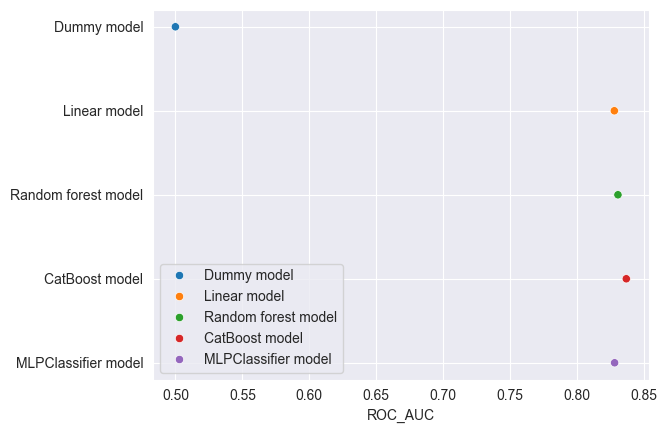

In [77]:
# Визуализируем результаты

display(search_results.sort_values(by=['ROC_AUC'], ascending=False))

sns.scatterplot(data=search_results, x = 'ROC_AUC', y=list(search_results.index), hue=list(search_results.index))
plt.grid(True)
plt.show()

Выиграла модель CatBoostClassifier

# Тестирование модели и демонстрация ее работы

- Проверьте качество лучшей модели на тестовой выборке.
    - Значение метрики ROC-AUC должно быть не менее 0.85.
    - Для интерпретируемости модели дополнительно выведите значение accuracy.
- Постройте матрицу ошибок лучшей модели. Отобразите полноту и точность модели на графике.
- Проанализируйте важность основных входных признаков, влияющих на отток клиентов.
- Для одного из важных входных признаков проведите дополнительное исследование:
    - Покажите график зависимости входного и целевого признаков.

In [78]:
testing_model = cb_grid.best_estimator_

In [80]:
predictions = testing_model.predict(X_test)

In [81]:
y_pred_proba = testing_model.predict_proba(X_test)[:, 1]

# Вычисляем AUC-ROC на тестовом наборе данных
auc_roc = roc_auc_score(y_test, y_pred_proba)
print('AUC-ROC на тестовом наборе данных:', auc_roc)

AUC-ROC на тестовом наборе данных: 0.8511943167738437


,importance
feature,
cat__Type,36.318304
cat__OnlineSecurity,13.794956
cat__TechSupport,12.808850
num__TotalCharges,8.586218
cat__PaymentMethod,7.609126
cat__Dependents,3.733663
num__MonthlyCharges,3.707912
cat__InternetService,3.559049
cat__PaperlessBilling,3.356368


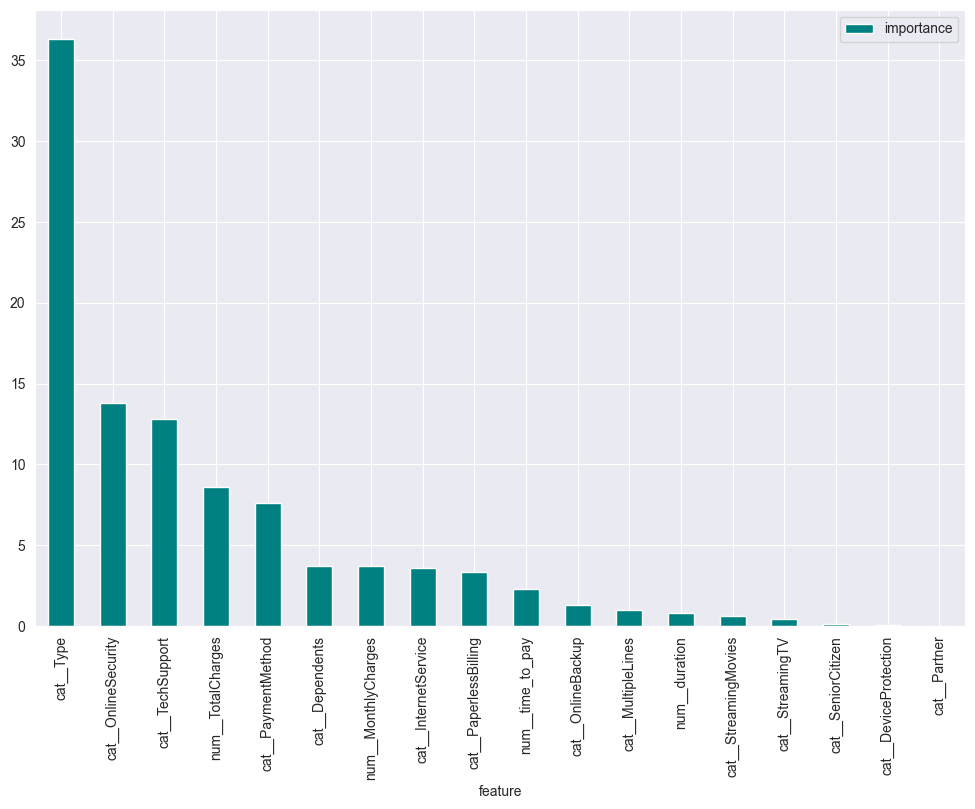

In [82]:
features = testing_model[:-1].get_feature_names_out()
feature_importances = testing_model[-1].feature_importances_

# Сохранение результатов в DataFrame
fi_df = pd.DataFrame(
    {'feature': features, 'importance': feature_importances}
).sort_values('importance', ascending = False)

# Вывод важности признаков
fi_df.set_index('feature', inplace=True)
display(fi_df.head(10))

fi_df.plot.bar(color = 'teal', figsize=(12, 8));

Из графика важности признаков у лучшей модели можно сделать вывод, что самыми значимыми признаками являются ['Type', 'OnlineSecurity', 'TechSupport', 'TotalCharges', 'PaymentMethod']

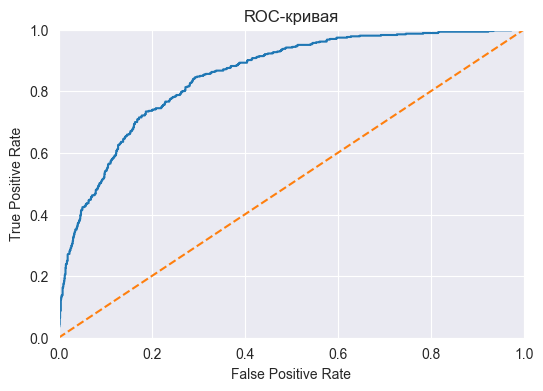

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Положение кривой относительно диагонали: Диагональная пунктирная линия представляет собой случайное предположение (т.е. классификатор, не обладающий способностью к распознаванию). Хорошая кривая ROC - это кривая, которая изгибается к верхнему левому углу, что указывает на высокий процент истинных положительных результатов и низкий процент ложных срабатываний. В этом случае кривая значительно выше диагонали по всей своей длине, что говорит о том, что классификатор работает намного лучше, чем случайное угадывание.

Площадь под кривой (AUC): Ключевым показателем эффективности классификатора, представленным кривой ROC, является площадь под кривой (AUC). Значение AUC, равное 1,0, представляет собой идеальный классификатор, в то время как значение AUC, равное 0,5, представляет собой бесполезный классификатор (эквивалентный случайному угадыванию). Кривая ROC на изображении имеет высокое значение AUC, близкое к 1,0, что указывает на очень хорошую производительность модели.

Охват кривой по направлению к Верхнему левому углу: Верхний левый угол графика (TPR = 1, FPR = 0) является идеальной точкой для классификатора. Эта кривая ROC находится довольно близко к верхнему левому краю, что означает, что классификатор может достичь высокого уровня истинно положительных результатов без существенного увеличения уровня ложноположительных результатов.

Форма кривой: Эта кривая быстро поднимается к высокому TPR при низком FPR, а затем более плавно переходит к более высокому FPR. Это говорит о том, что при правильном выборе порога классификатор может достичь высокой чувствительности (TPR) при сохранении достаточно низкого уровня выпадений (FPR).

Таким образом, эта кривая ROC показывает, что классификатор обладает высокой предсказательной способностью и способен эффективно различать два класса, что делает его надежной моделью, основанной на этом конкретном показателе.

Проведём графический анализ «Матрица ошибок». Выведем полноту и точность на график.

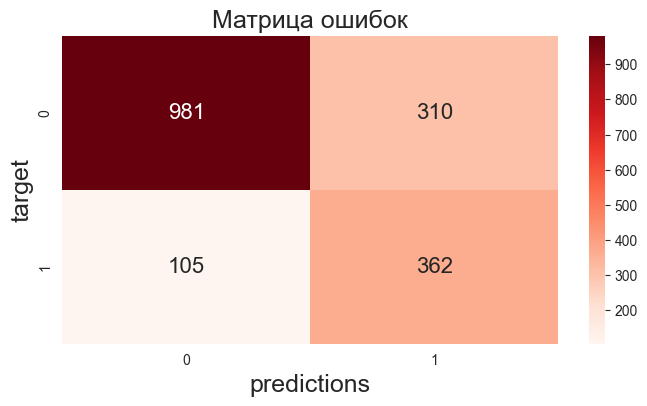

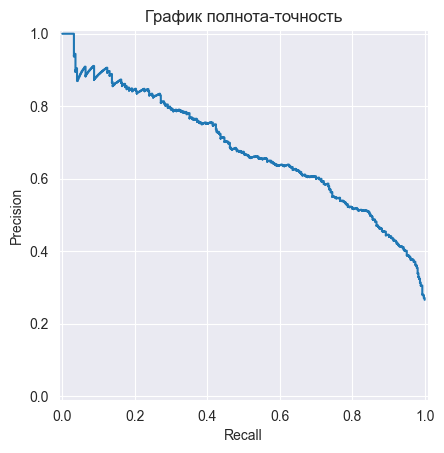

In [84]:
# Создадим матрицу ошибок CBC
cm_cbc = confusion_matrix(y_test, predictions)
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);


prec, recall, _ = precision_recall_curve(y_test, y_pred_proba)
PrecisionRecallDisplay(prec, recall).plot()# ax=ax2)
plt.title('График полнота-точность')
plt.show()

#### Матрица Ошибок (Confusion Matrix)

Матрица ошибок показывает количество правильных и неправильных прогнозов, сделанных моделью. Матрица ошибок выглядит так:
- **True Negative (Истинно отрицательные):** 981 - модель правильно предсказала, что эти случаи не принадлежат к классу 1.
- **False Positive (Ложно положительные):** 310 - модель неверно предсказала, что эти случаи принадлежат к классу 1.
- **False Negative (Ложно отрицательные):** 105 - модель неверно предсказала, что эти случаи не принадлежат к классу 1.
- **True Positive (Истинно положительные):** 362 - модель правильно предсказала, что эти случаи принадлежат к классу 1.

##### Анализ матрицы ошибок
- **Точность (Accuracy)** можно оценить как (981 + 362) / (981 + 310 + 105 + 362) = 1343 / 1758 ≈ 0.764, что является довольно высоким показателем.
- **Точность (Precision)** для класса 1 равна 362 / (362 + 310) ≈ 0.539, что указывает на то, что когда модель предсказывает класс 1, она права примерно в 53.9% случаев.
- **Полнота (Recall)** для класса 1 равна 362 / (362 + 105) ≈ 0.775, что означает, что модель обнаруживает 77.5% всех реальных случаев класса 1.

#### Кривая Точности-Полноты (Precision-Recall curve)

Эта кривая показывает баланс между точностью и полнотой при различных пороговых значениях. Для идеальной модели кривая должна стремиться к верхнему правому углу.

##### Анализ кривой
- В начале кривая находится на уровне высокой точности, но по мере того как полнота увеличивается (модель стремится включить больше положительных случаев), точность падает. Это обычное явление, так как включение большего числа положительных случаев часто приводит к увеличению числа ложно положительных результатов.
- На начальных стадиях, когда полнота относительно низкая, точность остаётся высокой. Это может быть полезно в приложениях, где важнее избежать ложных срабатываний.

#### Вывод
Модель показывает достаточно хорошие результаты по метрикам точности и полноты, а также обладает приемлемой точностью по матрице ошибок. Однако выбор модели зависит от конкретных требований вашего приложения: если критично не пропускать положительные случаи, стоит стремиться к высокой полноте; если важнее избежать ложных срабатываний, следует уделить внимание точности. В данном случае особых требований не было, поэтому соблюдён баланс

In [85]:
X_test['best_model_predicted_valid'] = predictions
predicted_1 = X_test[X_test['best_model_predicted_valid'] > 0]

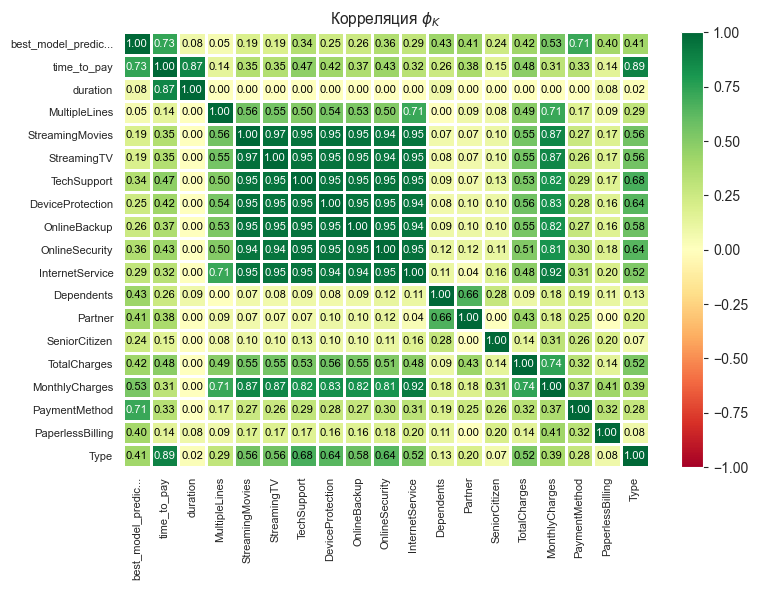

In [87]:
overview = correlation_matrix(X_test, interval_cols=['time_to_pay', 'duration', 'MonthlyCharges', 'TotalCharges'])

У предсказаний финальной модели самая большая корреляция с признаками ['PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'time_to_pay', 'Dependents', 'Type']

# Формулирование общих выводов

#### Цель работы
Исследовательский анализ данных позволил выявить важные закономерности и тенденции, связанные с оттоком клиентов у оператора связи «ТелеДом». Были определены ключевые признаки, влияющие на решение клиентов отказаться от услуг связи. Основываясь на этих результатах, оператор может разработать стратегии для удержания клиентов и снижения оттока, например, предлагая специальные условия и промокоды тем, кто планирует сменить провайдера.
Анализ показал, что пожилые люди чаще отказываются от услуг, чем более молодые клиенты. Пользователи без доступа в интернет реже отказываются от услуг, чем те, у кого есть доступ. Пользователи с приоритетной технической поддержкой (TechSupport) гораздо реже отказываются от услуг, а пользователи с дополнительной услугой DeviceProtection чаще отказываются от услуг. Пользователи с услугой OnlineBackup не отказываются от услуг, а пользователи с услугой OnliveSecurity реже отказываются от услуг. Пользователи с услугой InternetService также реже отказываются от услуг.
Эти результаты могут быть использованы для разработки персонализированных предложений и улучшения качества обслуживания, что в свою очередь поможет снизить отток клиентов и повысить лояльность к бренду.

#### Общие выводы:
Анализ данных позволил выявить ключевые факторы, влияющие на отток клиентов у оператора связи «ТелеДом».
- Модель Catboost показала хорошие результаты с AUC-ROC равной 0,85, что говорит о её высокой эффективности в предсказании оттока клиентов.
- Наиболее значимыми признаками оказались ['Type', 'OnlineSecurity', 'TechSupport', 'TotalCharges', 'PaymentMethod']. Это указывает на важность учёта платёжных предпочтений клиентов, размера ежемесячных и общих платежей, а также времени, затрачиваемого на оплату услуг.
- Однако корреляционный анализ предсказаний модели дополнил выводы о важности признаков - признак 'time_to_pay': время до оплаты сильно коррелирует с теми клиентами, которые модель считает не надежными.

#### Способы для дальнейшего улучшения модели:
- Расширение обучающей выборки для повышения точности модели.
- Добавление новых признаков, таких как история использования услуг, предпочтения в использовании дополнительных сервисов и т. д., для более глубокого понимания поведения клиентов.
- Использование методов машинного обучения, способных работать с несбалансированными данными, чтобы улучшить предсказание для редких случаев оттока.
#### Бизнес-рекомендации заказчику:
- Разработать программы лояльности и специальные предложения для клиентов, которые находятся в зоне риска оттока.
- Оптимизировать процесс подключения и настройки услуг, чтобы сократить время, затрачиваемое на оплату услуг.
- Улучшить качество технической поддержки и предложить дополнительные услуги, такие как DeviceProtection и OnlineBackup, чтобы повысить удовлетворённость клиентов.
- Рассмотреть возможность внедрения PaperlessBilling для снижения вероятности оттока среди клиентов, которые не замечают, сколько платят.
- Проанализировать возможность предоставления годовой подписки для снижения оттока среди клиентов, которые предпочитают долгосрочные контракты.
- Предоставление промокодов клиентов с высокой вероятностью ухода ближе к сроку оплаты счета по контракту.